# 0.0. IMPORTS

In [60]:
import pandas as pd
import seaborn as sns
import inflection
import numpy as np
import math
from matplotlib import pyplot as plt
from IPython.display import Image
from datetime import datetime
from datetime import timedelta
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y ).values        
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0] 
    chi2corr = max(0, chi2 - (k - 1) * ( r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1,rcorr - 1)) )

In [ ]:
sns.set()

## 0.2. Loading data

In [3]:
df_train_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_train_raw, df_store_raw, on='Store', how='left')

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
col_old = df1.columns
df1.columns = map(inflection.underscore, col_old)
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [6]:
print(f'O número de linhas do dataset é {df1.shape[0]} e o de colunas é {df1.shape[1]}')

O número de linhas do dataset é 1017209 e o de colunas é 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
meses = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(meses)
df1['promo_interval'].fillna(0, inplace=True)
df1['is_promo'] = df1.apply(lambda x: 1 if str(x['month_map']) in str(x['promo_interval']).split(',') else 0, axis=1)

## 1.6. Change Type

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [12]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

mc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
mc2 = pd.DataFrame(num_attributes.apply(np.median)).T

md1 = pd.DataFrame(num_attributes.apply(np.std)).T
md2 = pd.DataFrame(num_attributes.apply(np.min)).T
md3 = pd.DataFrame(num_attributes.apply(np.max)).T
md4 = pd.DataFrame(num_attributes.apply(lambda x: np.max(x) - np.min(x))).T
md5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
md6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

Descriptive = pd.concat([mc1, mc2, md1, md2, md3, md4, md5, md6]).T.reset_index()
Descriptive.columns = ['Descrição','Media','Mediana','Desvio Padrão','Mínimo','Máximo','Range','Skew','Kurtosis']
Descriptive

,Descrição,Media,Mediana,Desvio Padrão,Mínimo,Máximo,Range,Skew,Kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


<AxesSubplot: xlabel='state_holiday', ylabel='sales'>

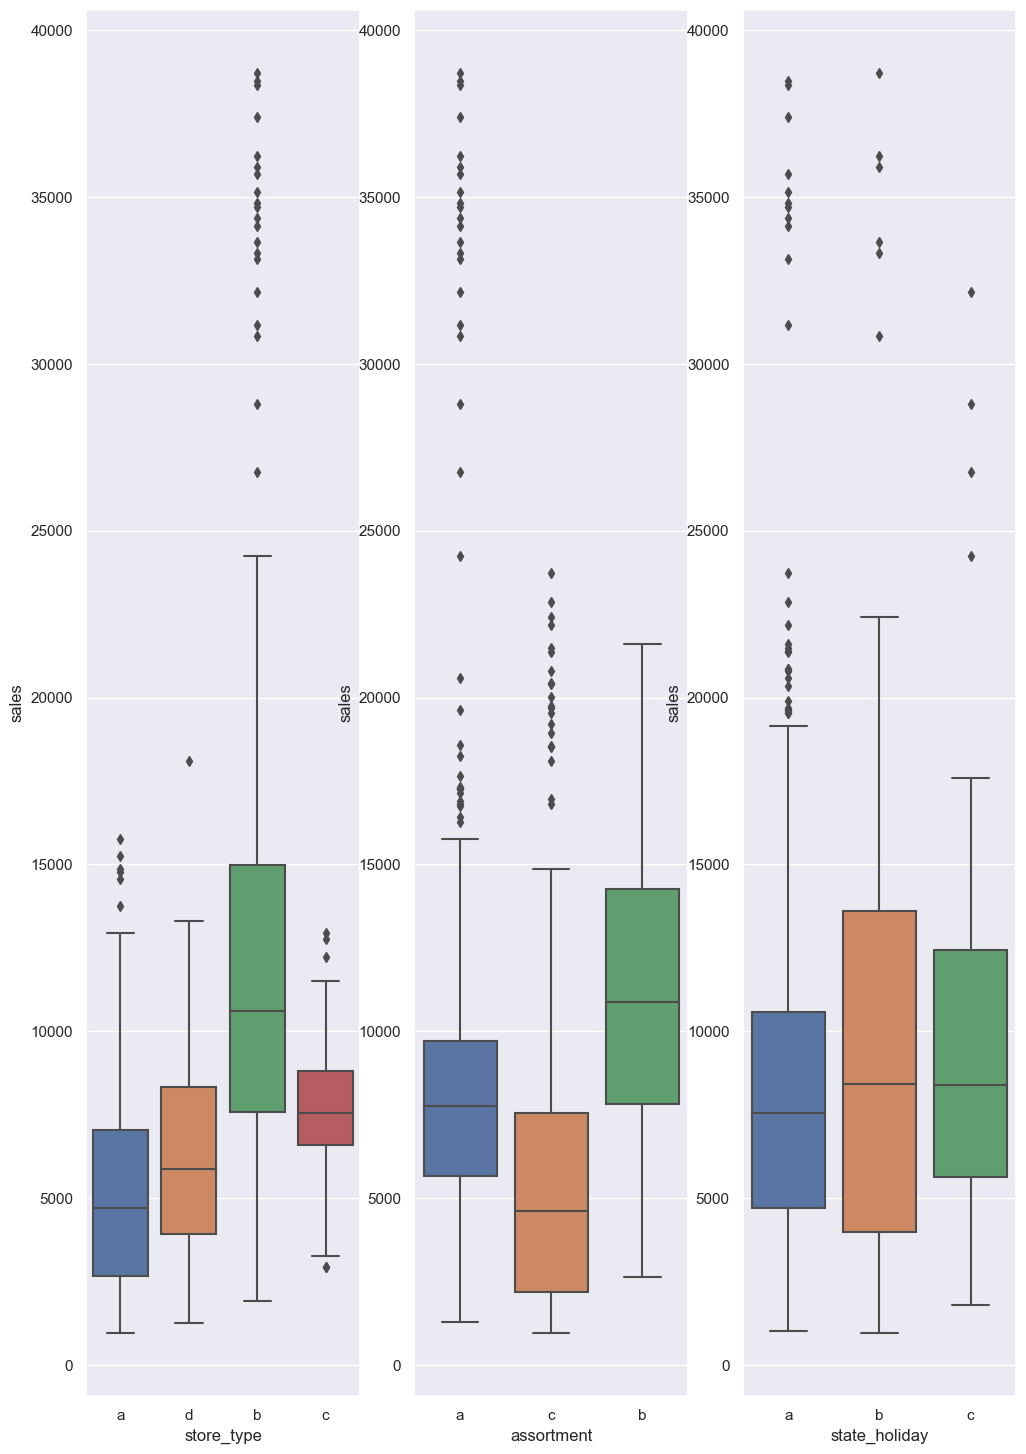

In [13]:
plt.figure(figsize = [12, 18])
aux1 = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot(1,3,1)
sns.boxplot(data = aux1, x = 'store_type' , y = 'sales' )

plt.subplot(1,3,2)
sns.boxplot(data = aux1, x = 'assortment' , y = 'sales' )

plt.subplot(1,3,3)
sns.boxplot(data = aux1, x = 'state_holiday' , y = 'sales' )

In [14]:
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime'])
cat_attributes

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: np.max(x) - np.min(x))).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [17]:
m = pd.concat([d2, d3, d4, ct1,ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_9988\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<AxesSubplot: xlabel='competition_distance', ylabel='Density'>

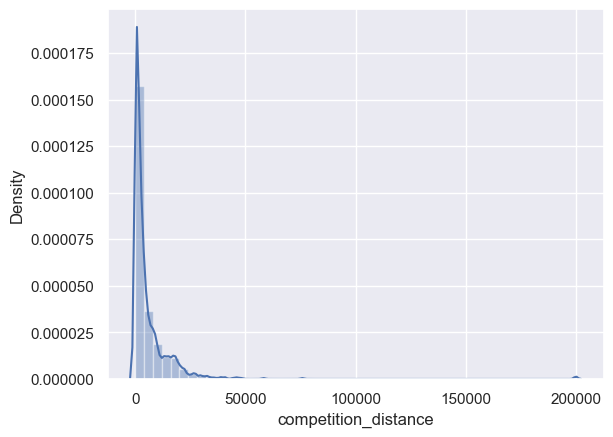

In [18]:
sns.distplot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

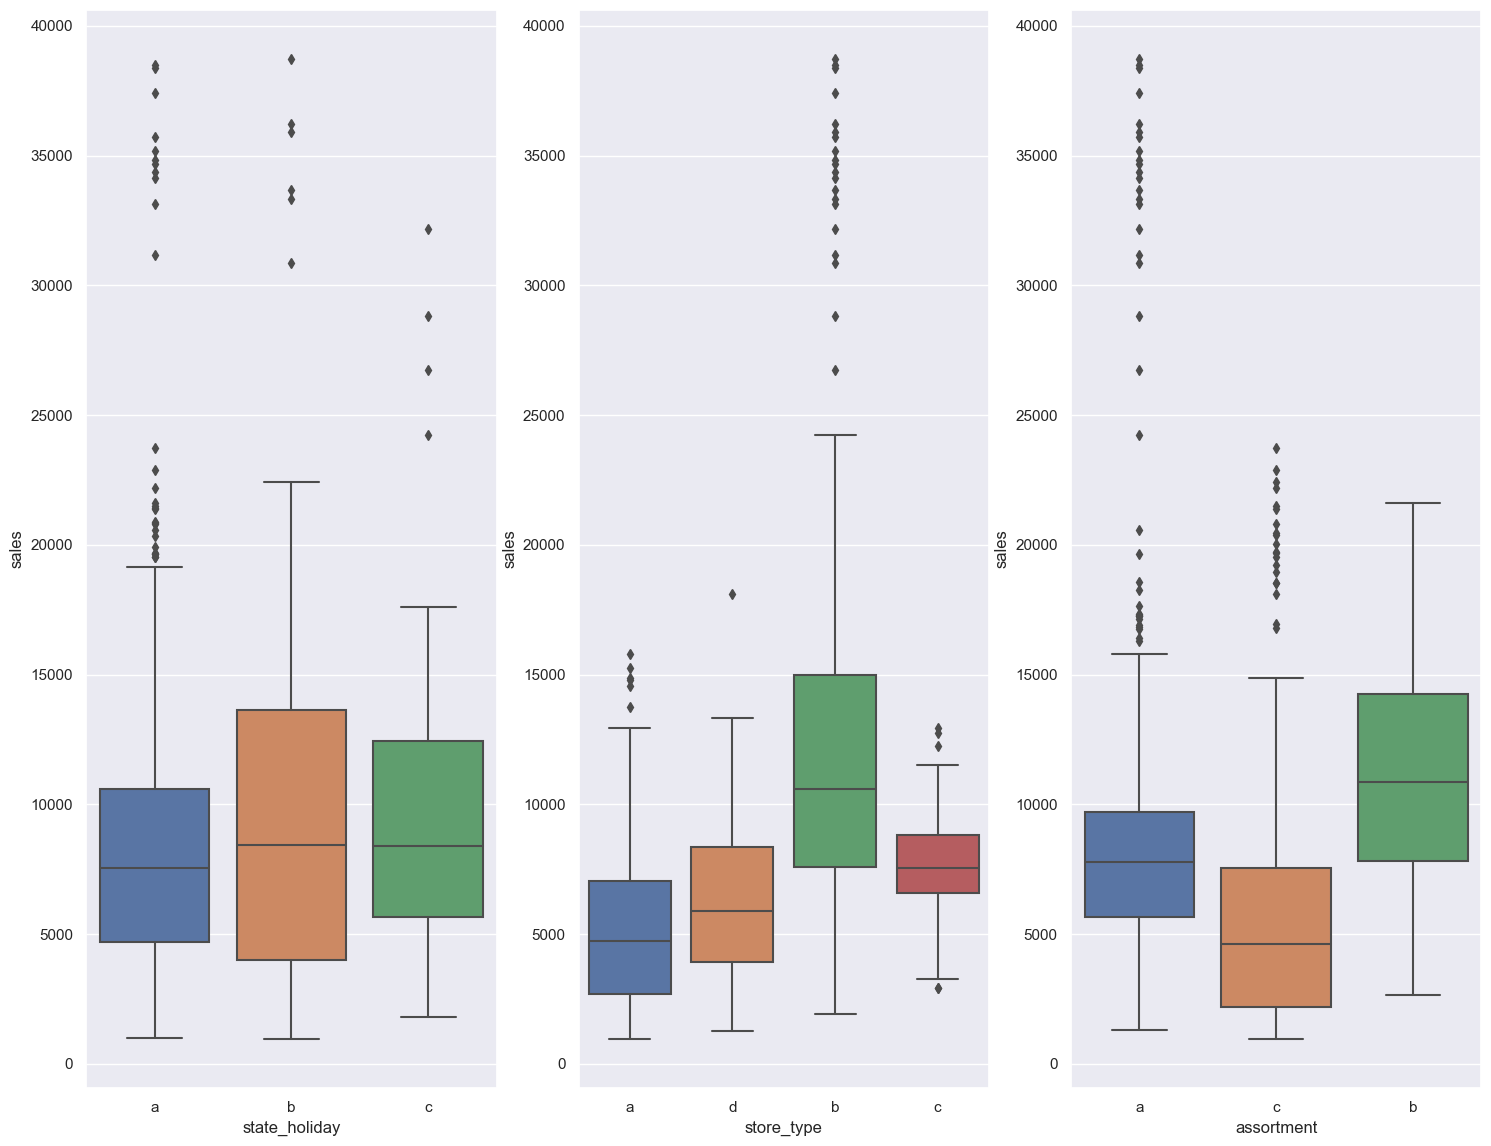

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=[18,14])

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

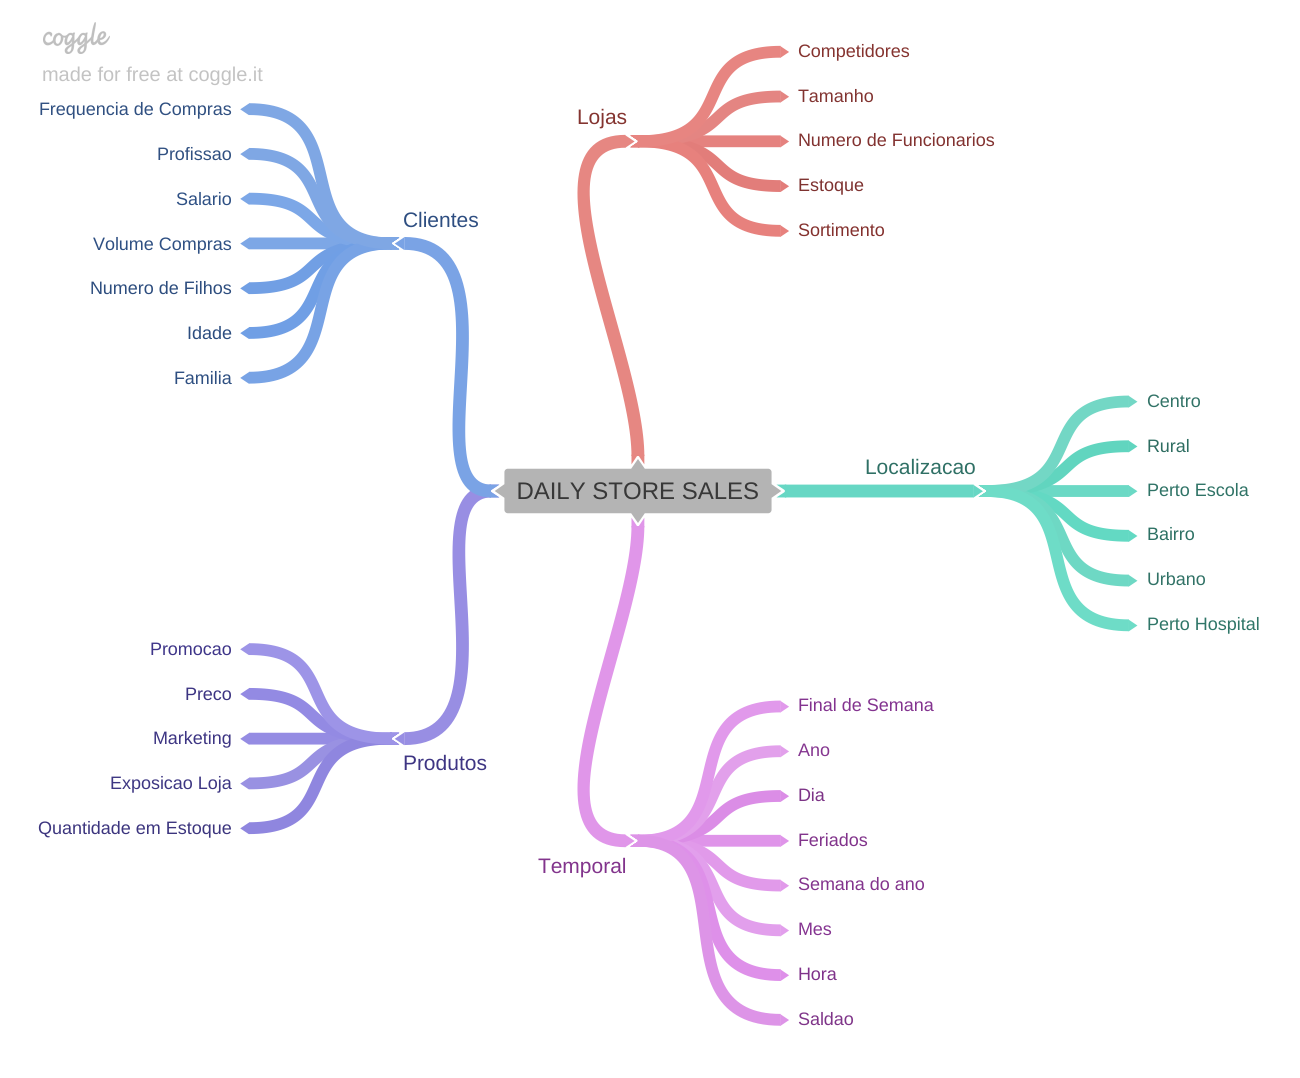

In [22]:
Image('img/DAILY_STORE_SALES.png')

## 2.1. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com competidores mais próximos deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais

**3.** Lojas que tem precos menores nos produtos deveriam vender mais

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].apply(lambda x: x.year)
# month
df2['month'] = df2['date'].apply(lambda x: x.month)
# Day
df2['day'] = df2['date'].apply(lambda x: x.day)
# Week of Year
df2['week_of_year'] = df2['date'].apply(lambda x: x.weekofyear)
# Year week
df2['year_week'] = df2['date'].apply(lambda x: str(x.year) + '-' + str(x.week))

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# competition_time_month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promo since
df2 = df2[df2['promo2_since_year'] != df2['promo2_since_week']]
df2['promo_since'] = (df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)).apply(lambda x: datetime.strptime( x + '-1', '%Y-%W-%w') - timedelta(days=7))

# promo_time_week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                           'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                 'easter_holiday' if x == 'b' else
                                                 'christmas' if x == 'c' else 'regular_day')

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [26]:
df3 = df3[(df3['sales'] > 0) & (df3['open'] == 1)]

## 3.2. Selecao das Colunas

In [27]:
drop_cols = ['open','customers','promo_interval','month_map']
df3 = df3.drop(drop_cols, axis = 1)

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DE DADOS

In [28]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_9988\2747941823.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde=False)


<AxesSubplot: xlabel='sales'>

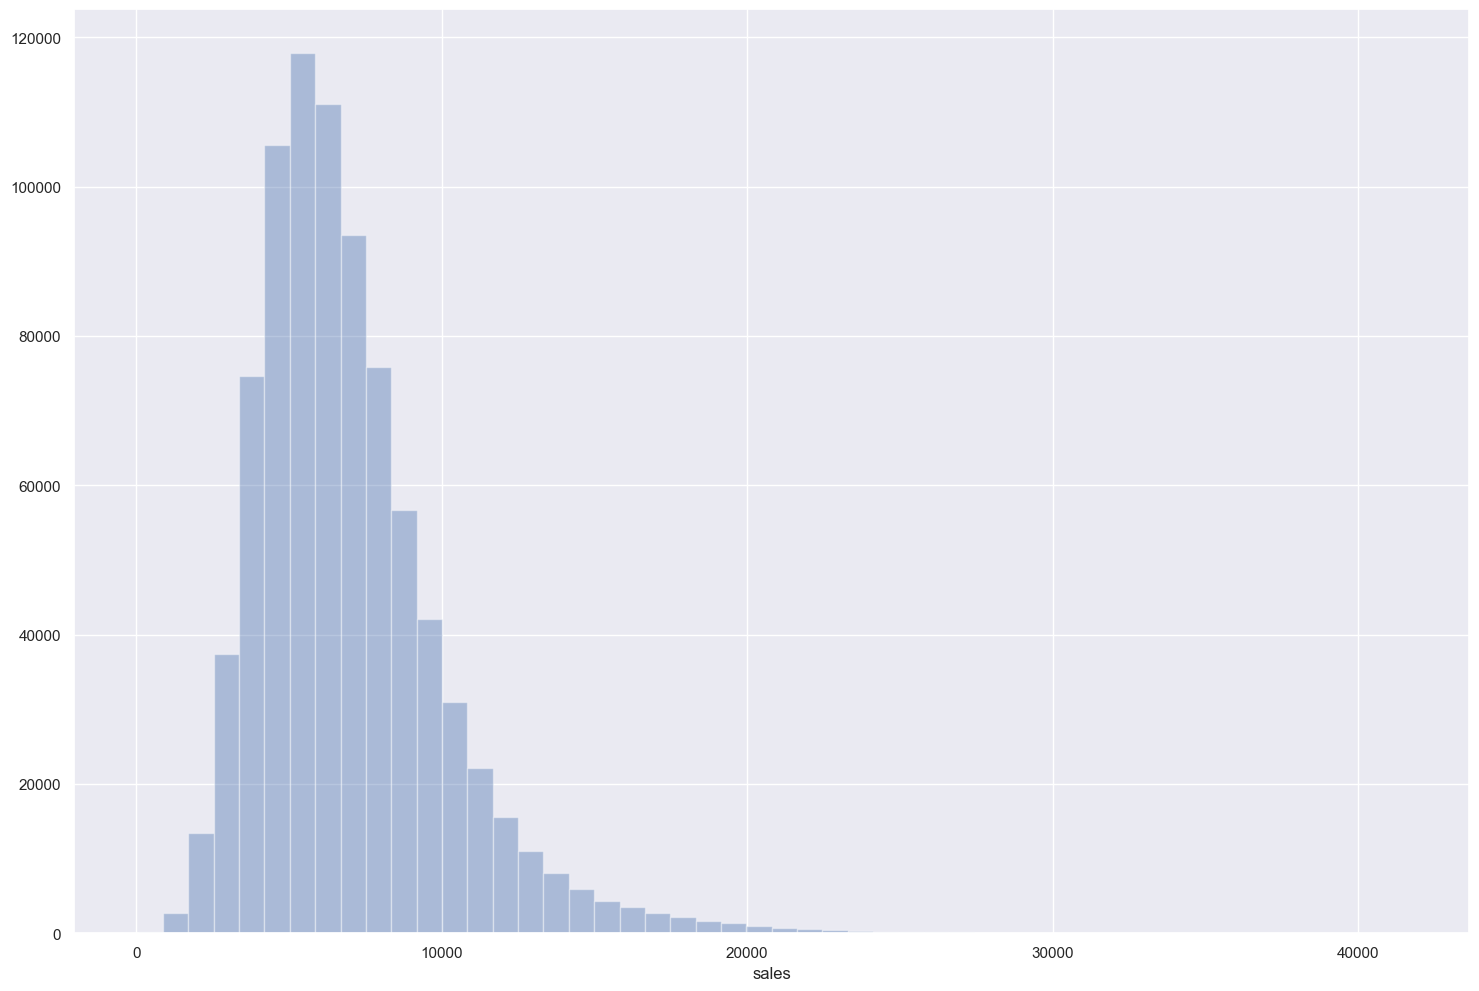

In [29]:
plt.figure(figsize=[18,12])
sns.distplot(df4['sales'], kde=False)

### 4.1.2. Numerical Variable

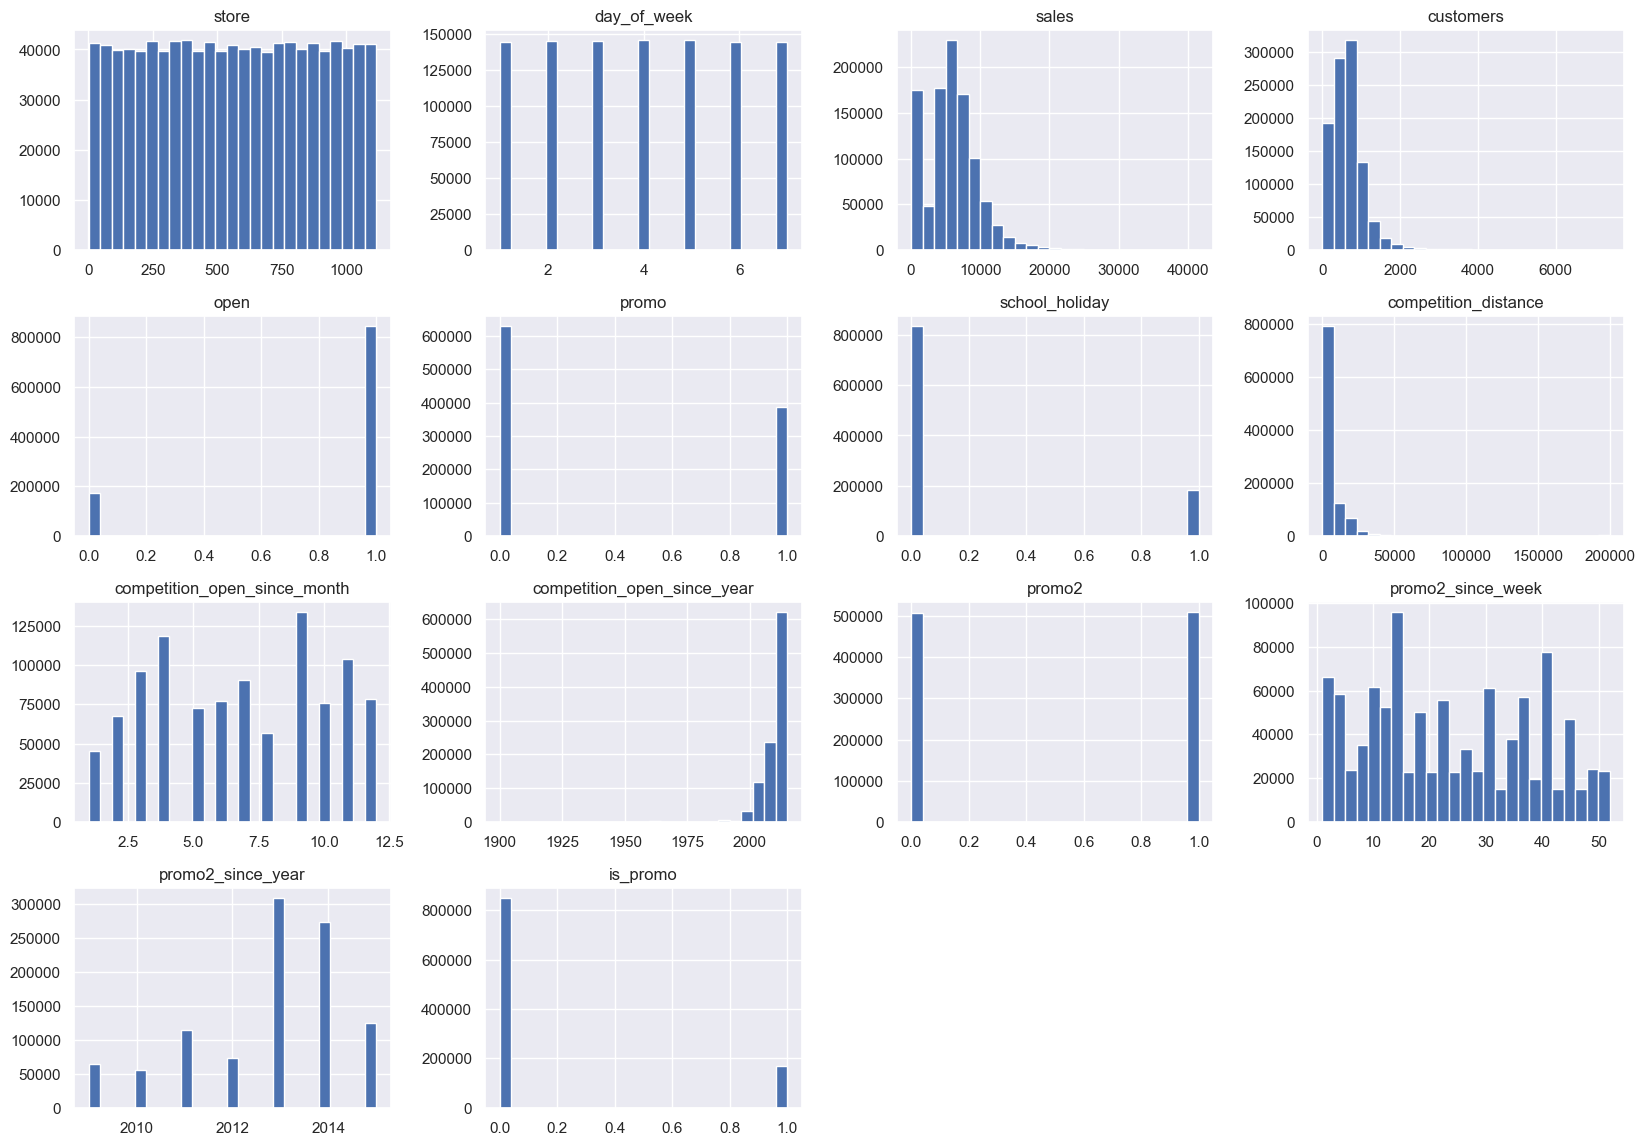

In [30]:
plt.rcParams['figure.figsize']=(20,14)
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [31]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [32]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_9988\3994559084.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_9988\3994559084.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_9988\3994559084.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
C:\Users\Ronal

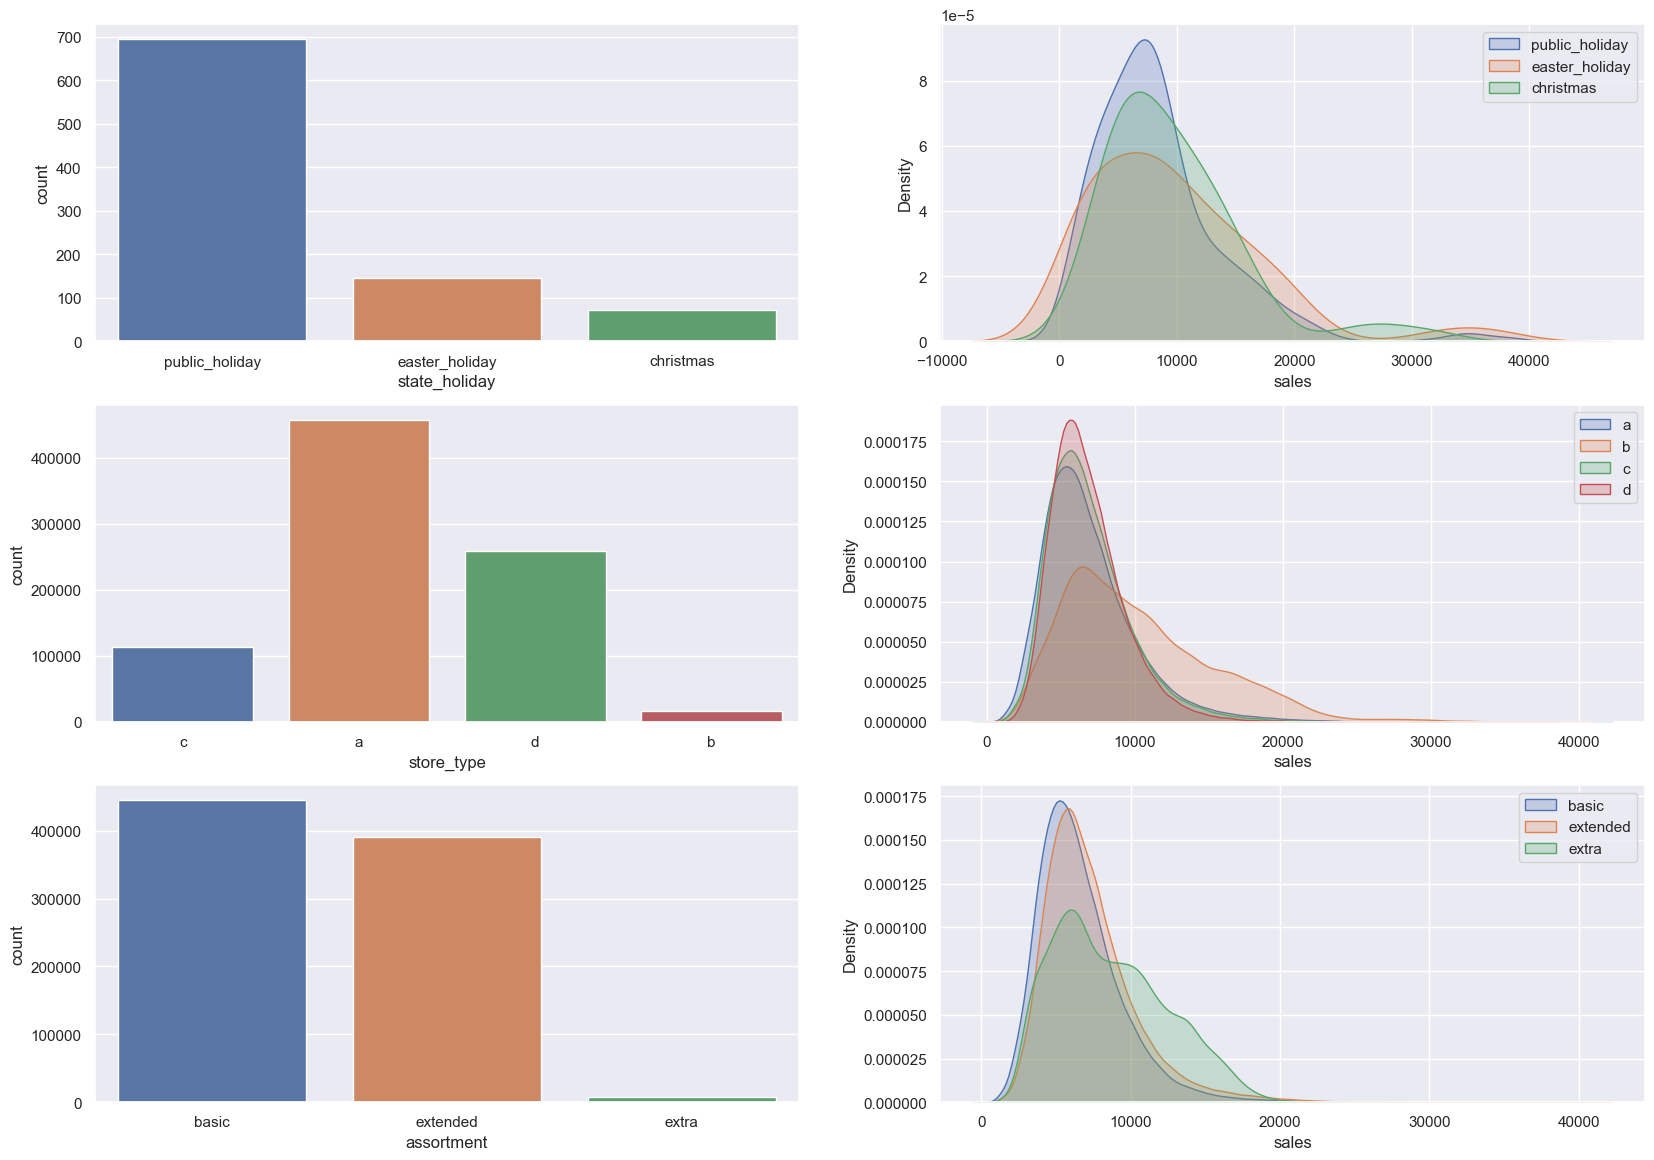

In [33]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

#store_type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

#assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)
plt.legend()

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

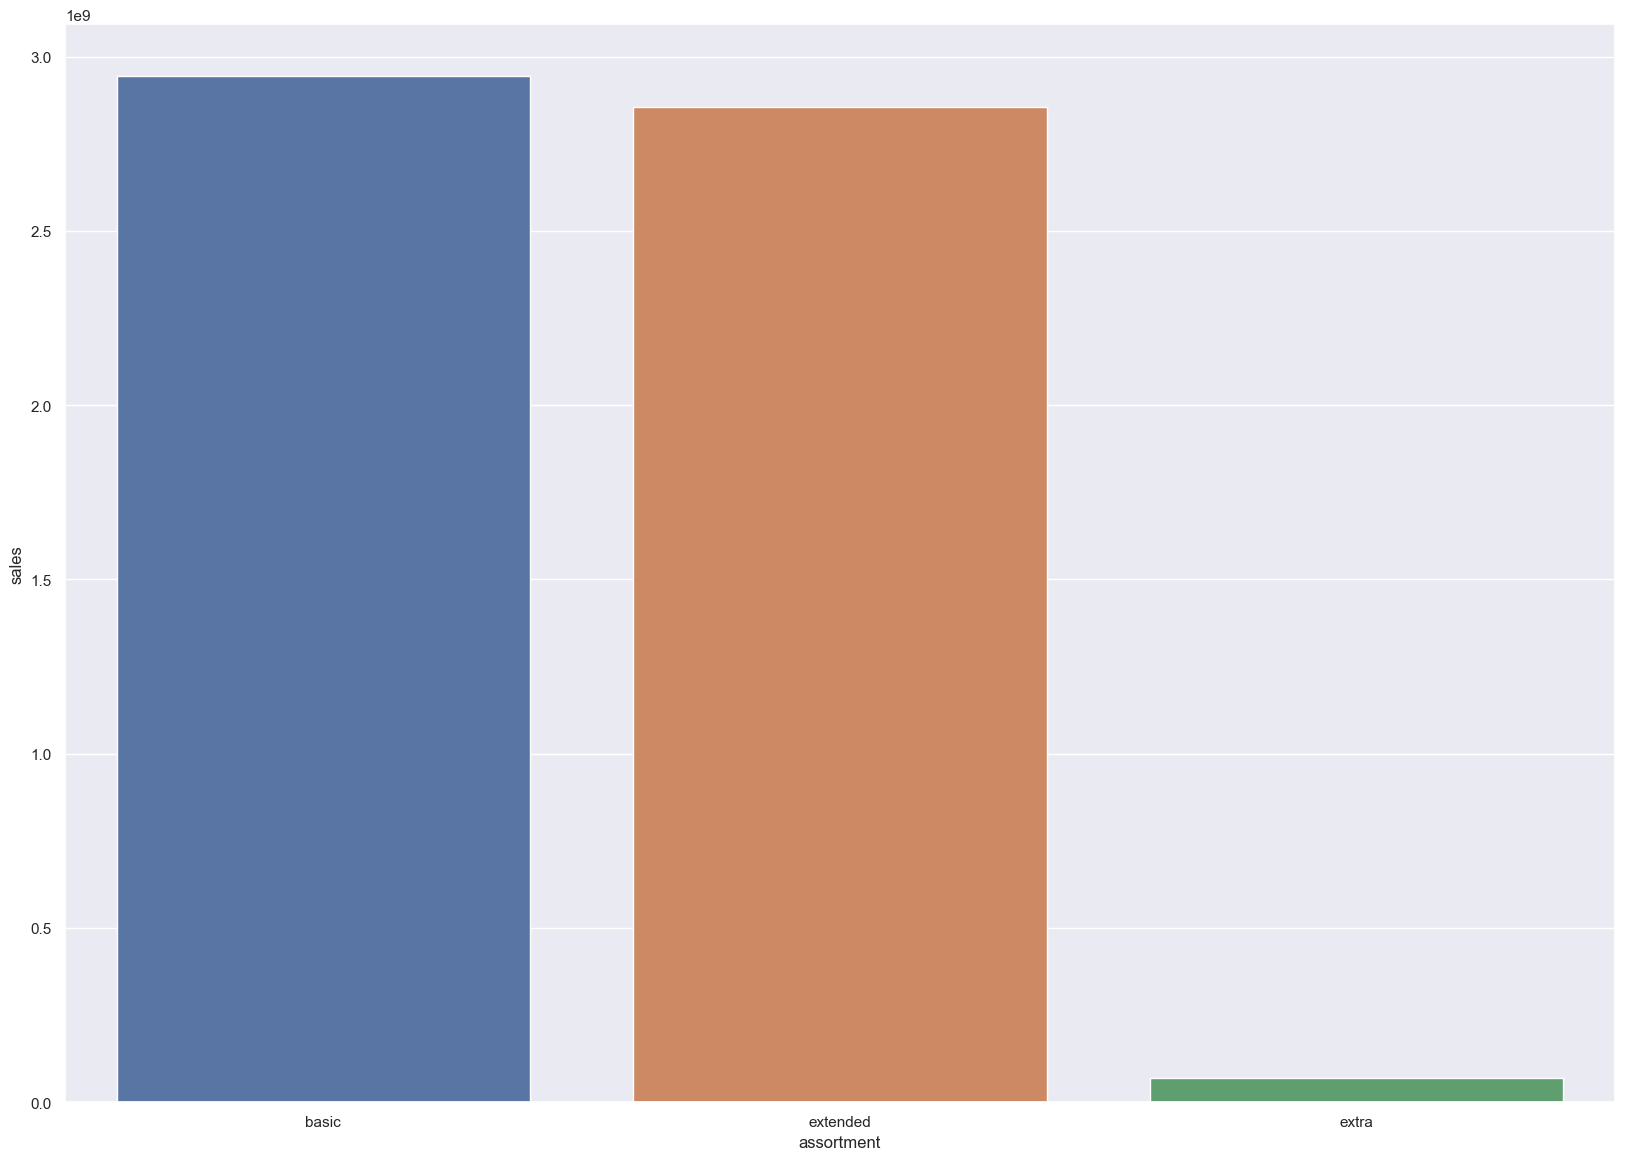

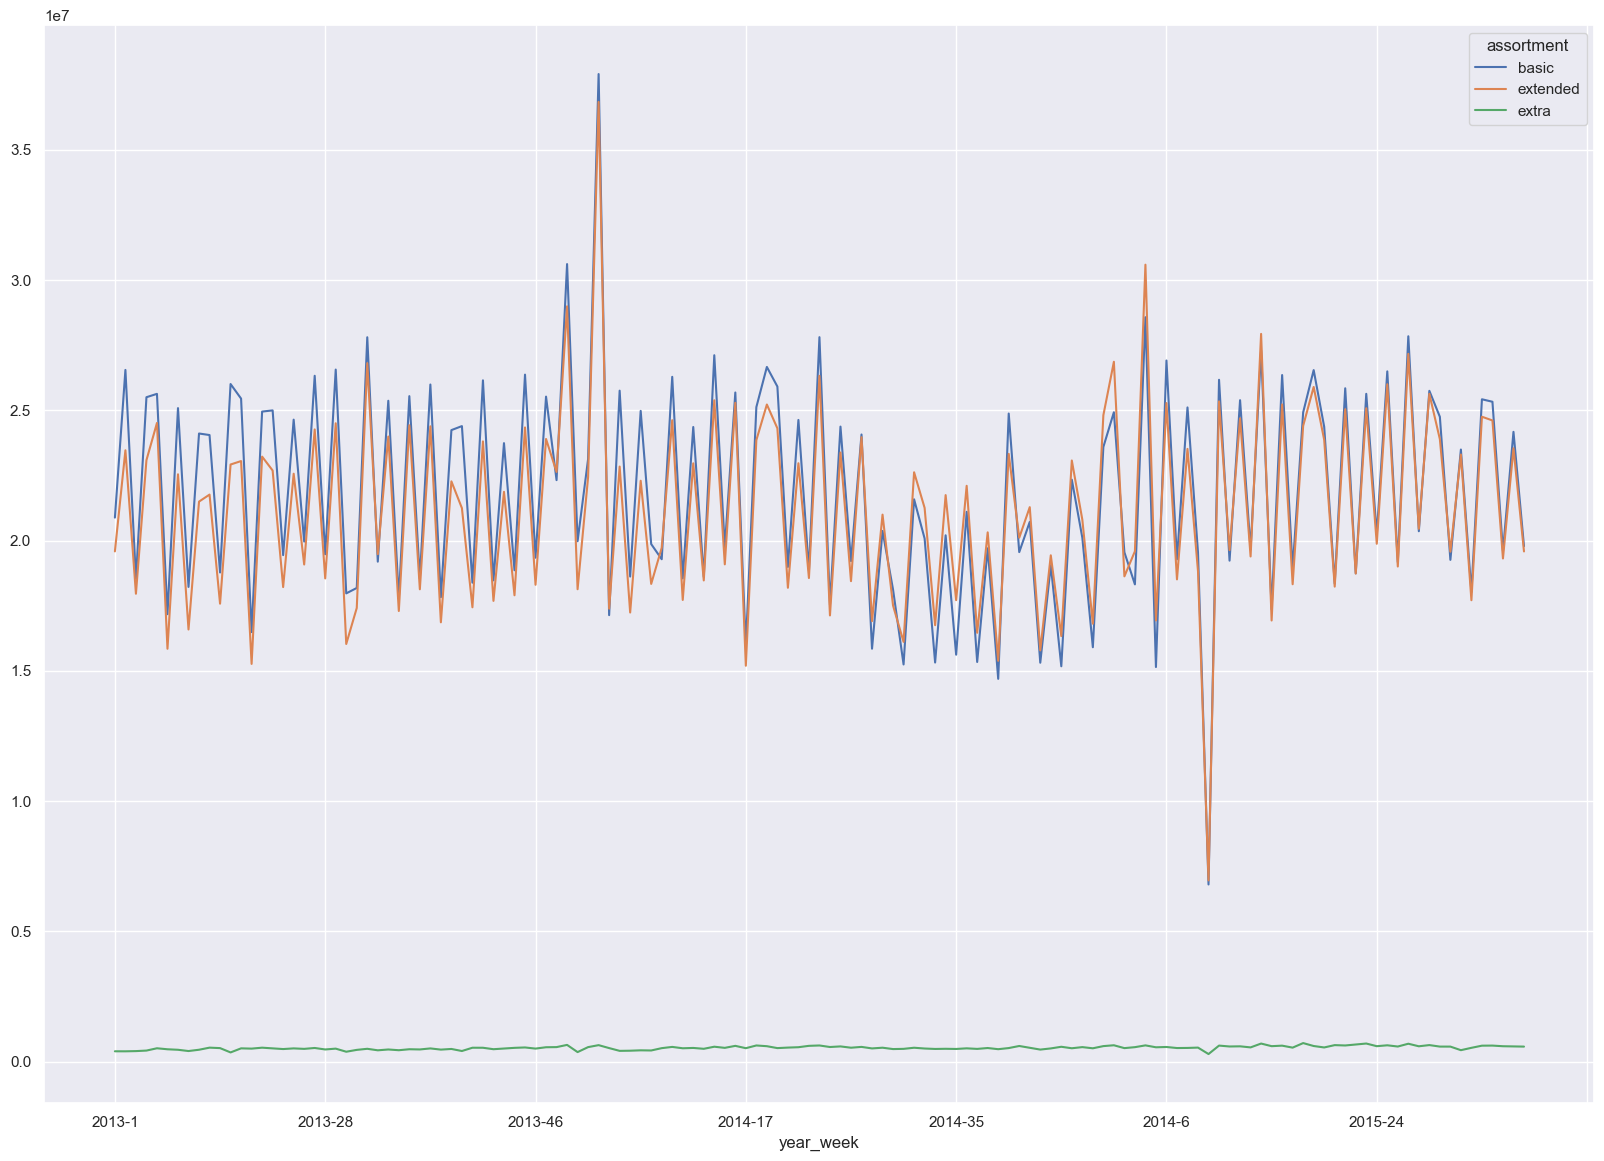

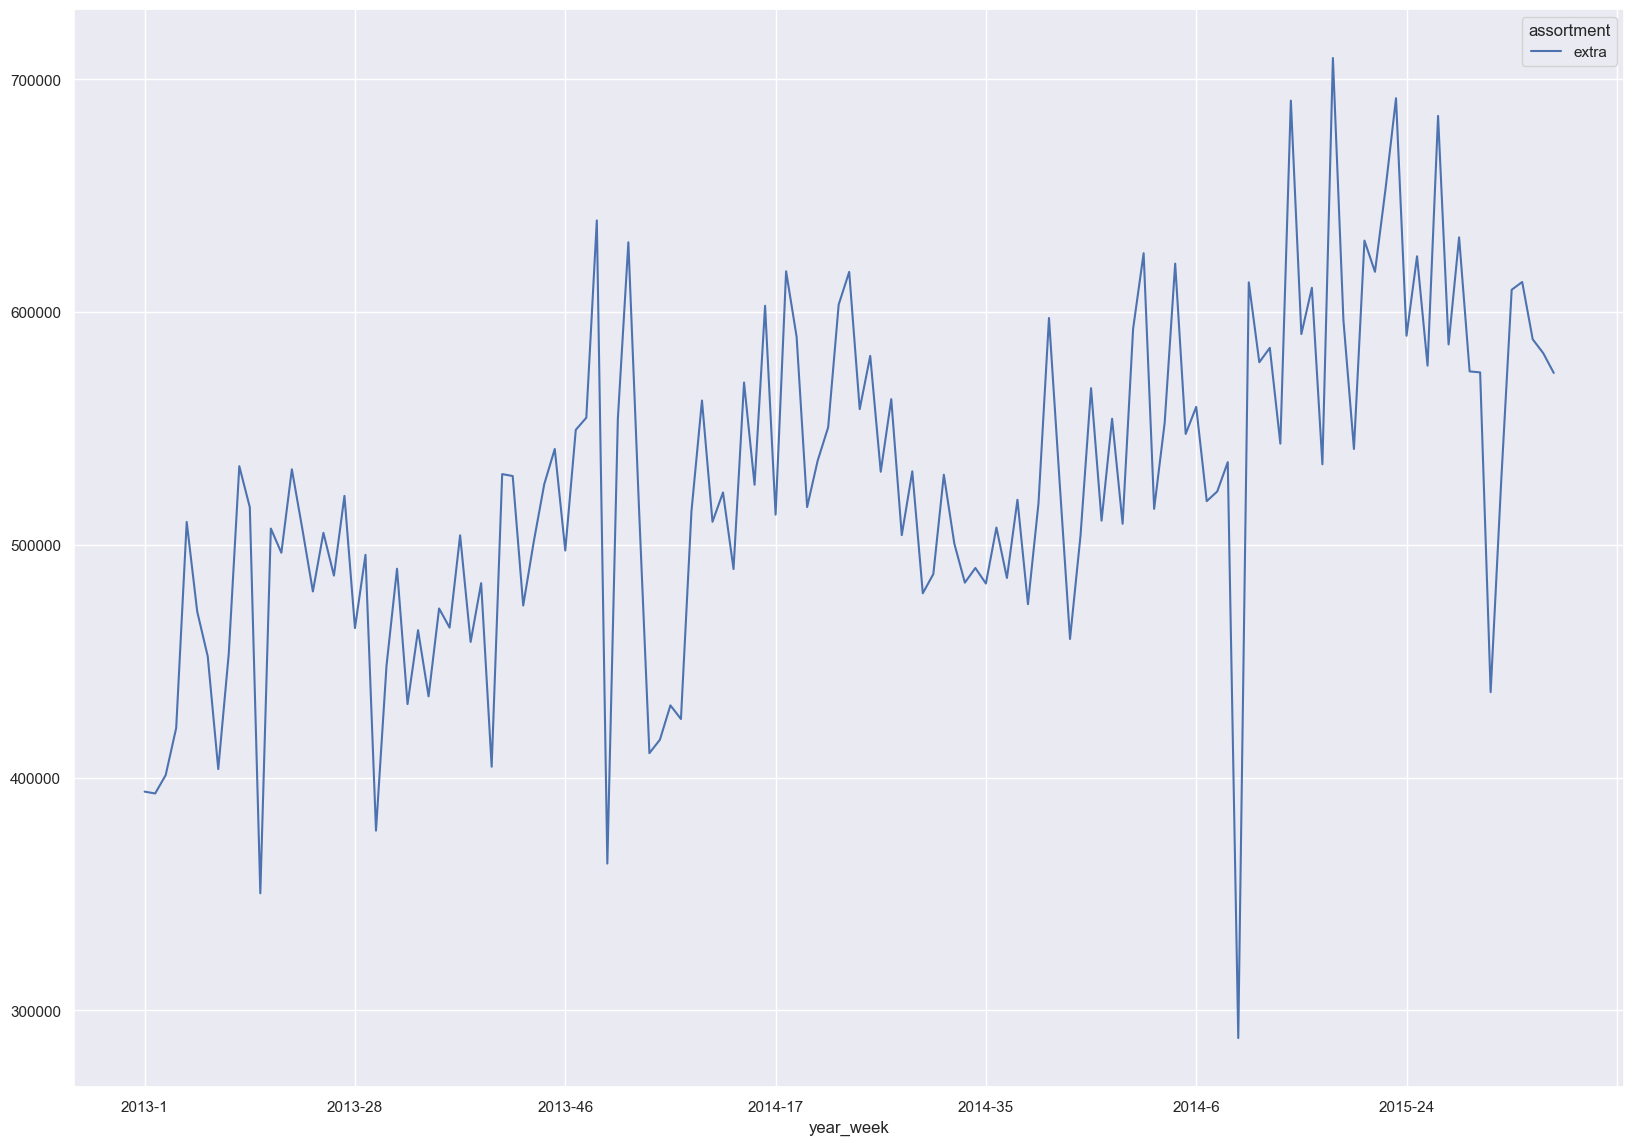

In [34]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_9988\4183937937.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


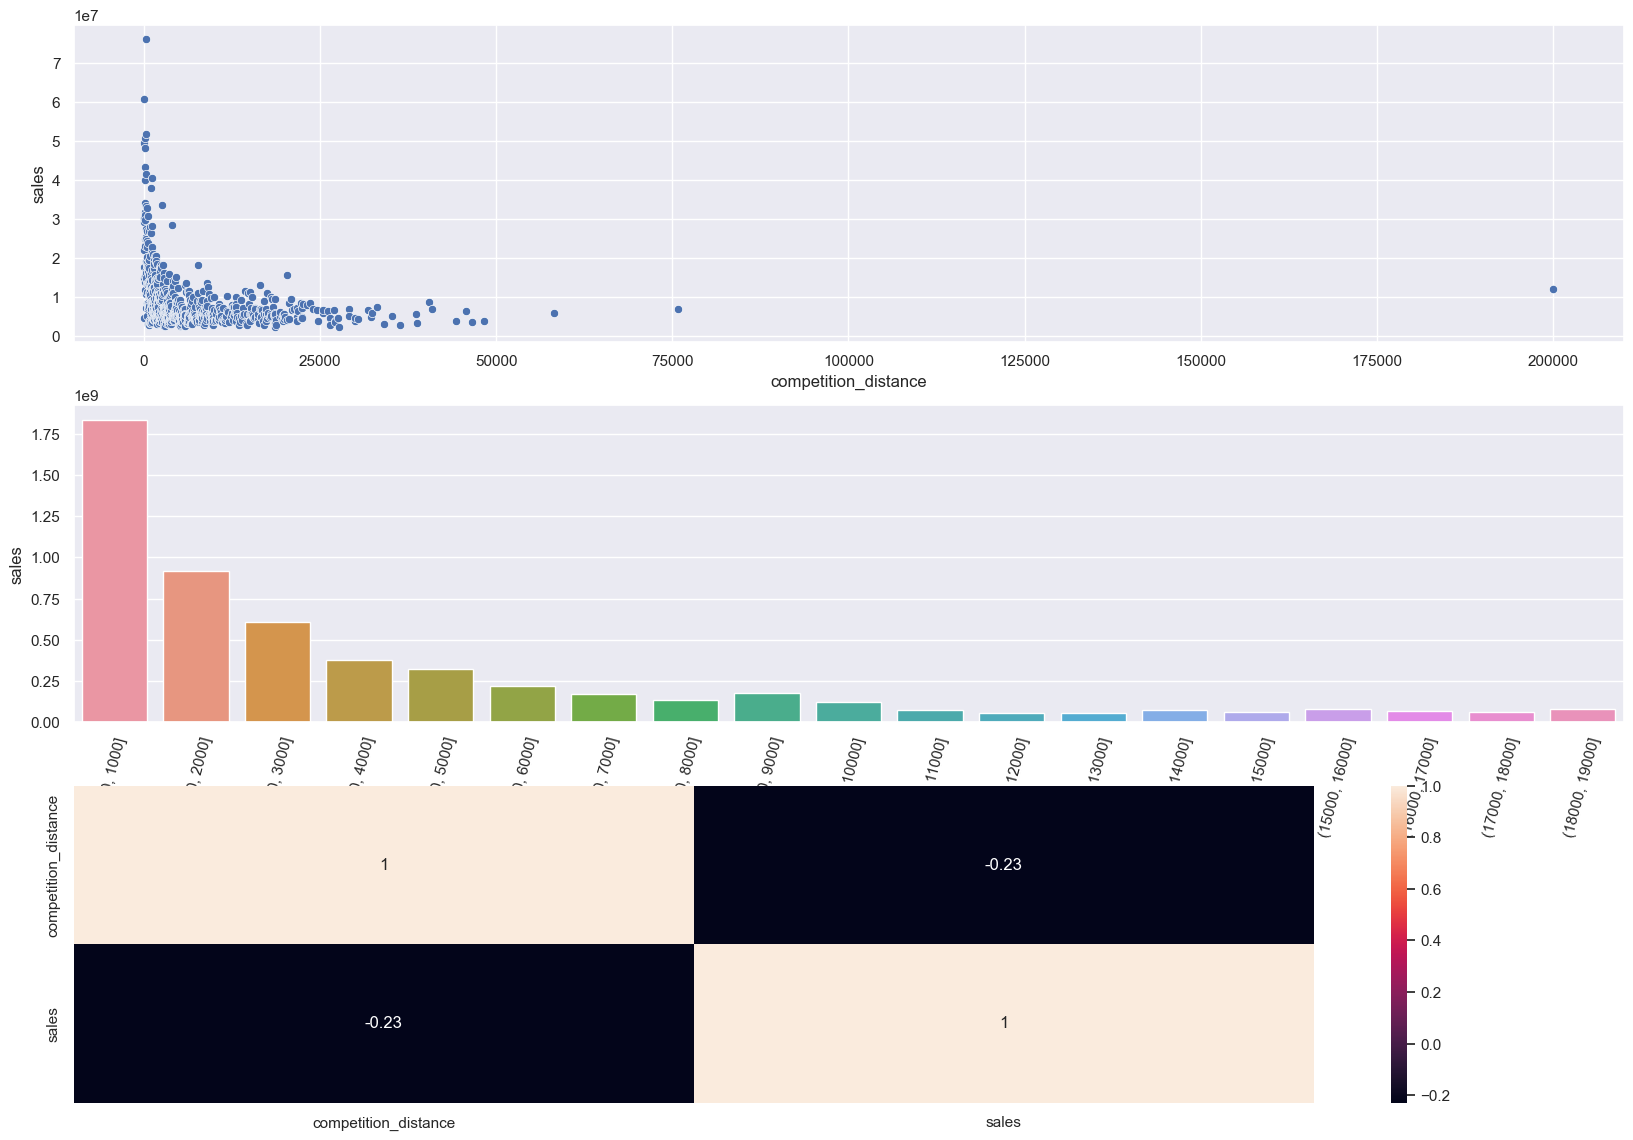

In [35]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(3,1,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(3,1,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
aux3 = sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation=75);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais
**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

<AxesSubplot: >

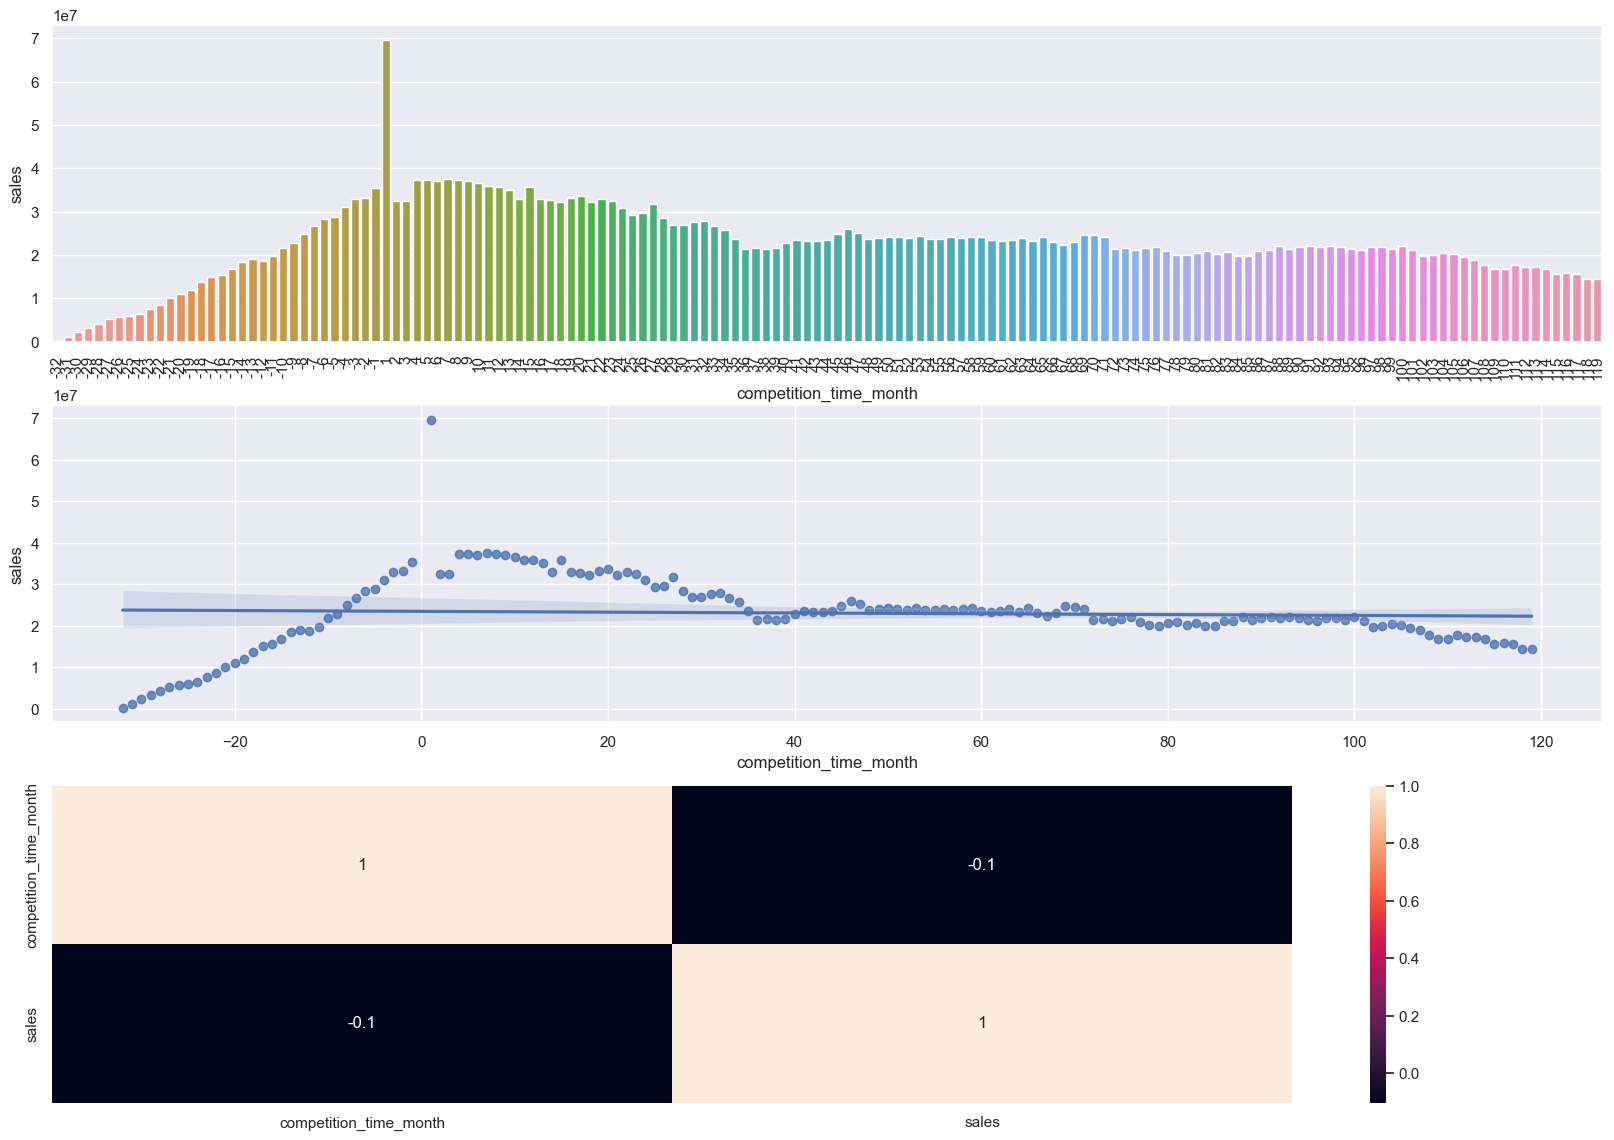

In [36]:
plt.subplot(3,1,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation=90)

plt.subplot(3,1,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promoções ATIVAS POR MAIS TEMPO vendem MENOS depois de um certo tempo de promoção.

<AxesSubplot: >

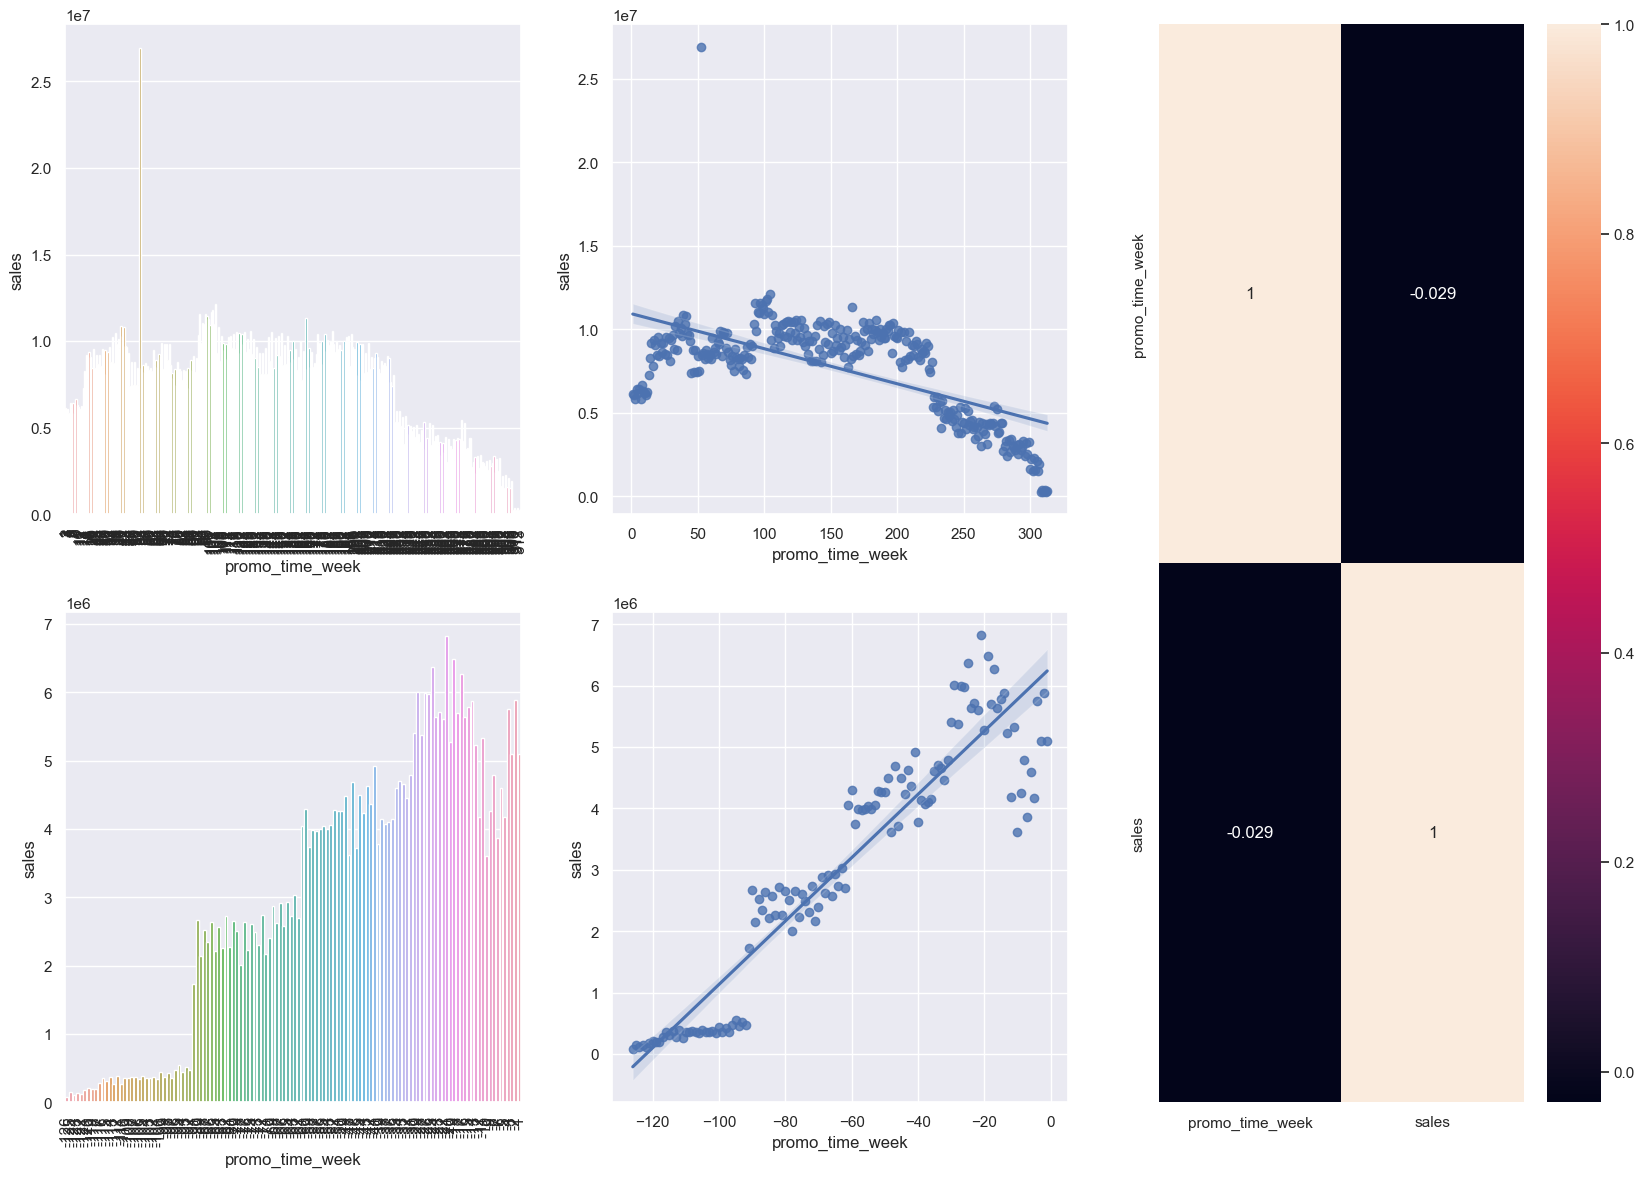

In [37]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index();

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais </s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais PROMOÇÕES CONSECUTIVAS vendem MENOS

In [38]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


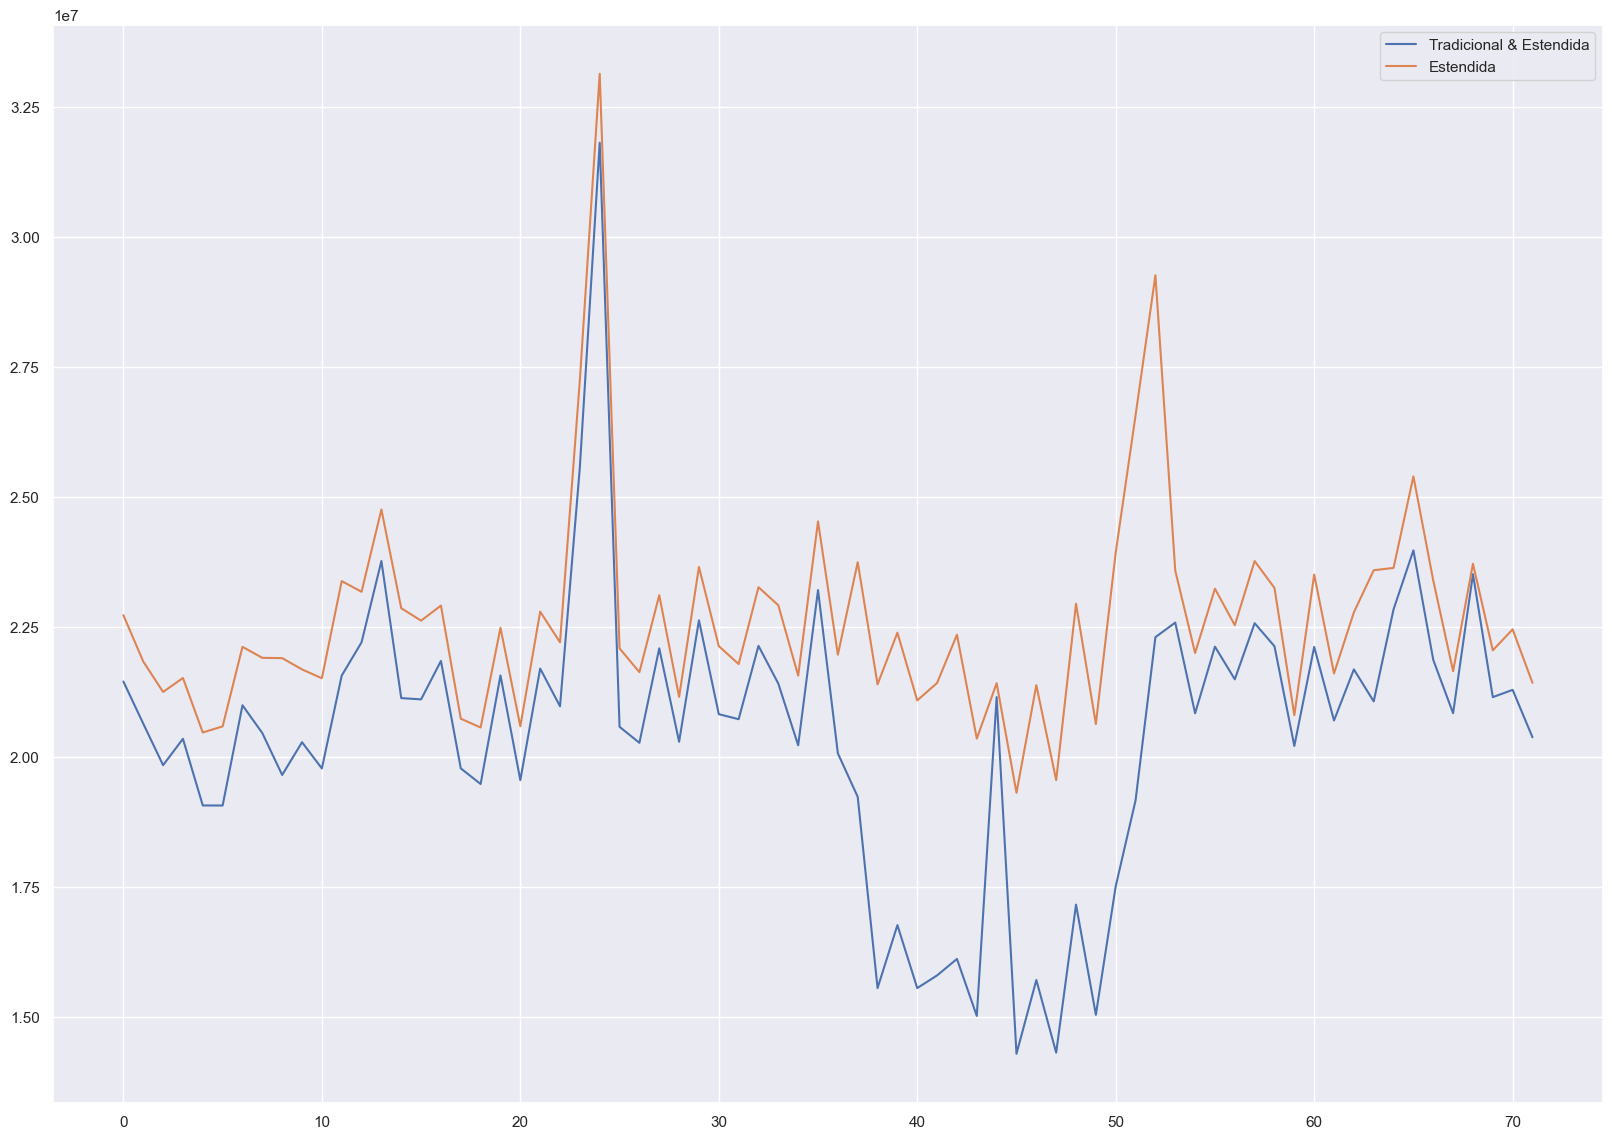

In [39]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Estendida', 'Estendida'])

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais
**FALSA** Lojas abertas durante o FERIADO DE NATAL vendem MENOS

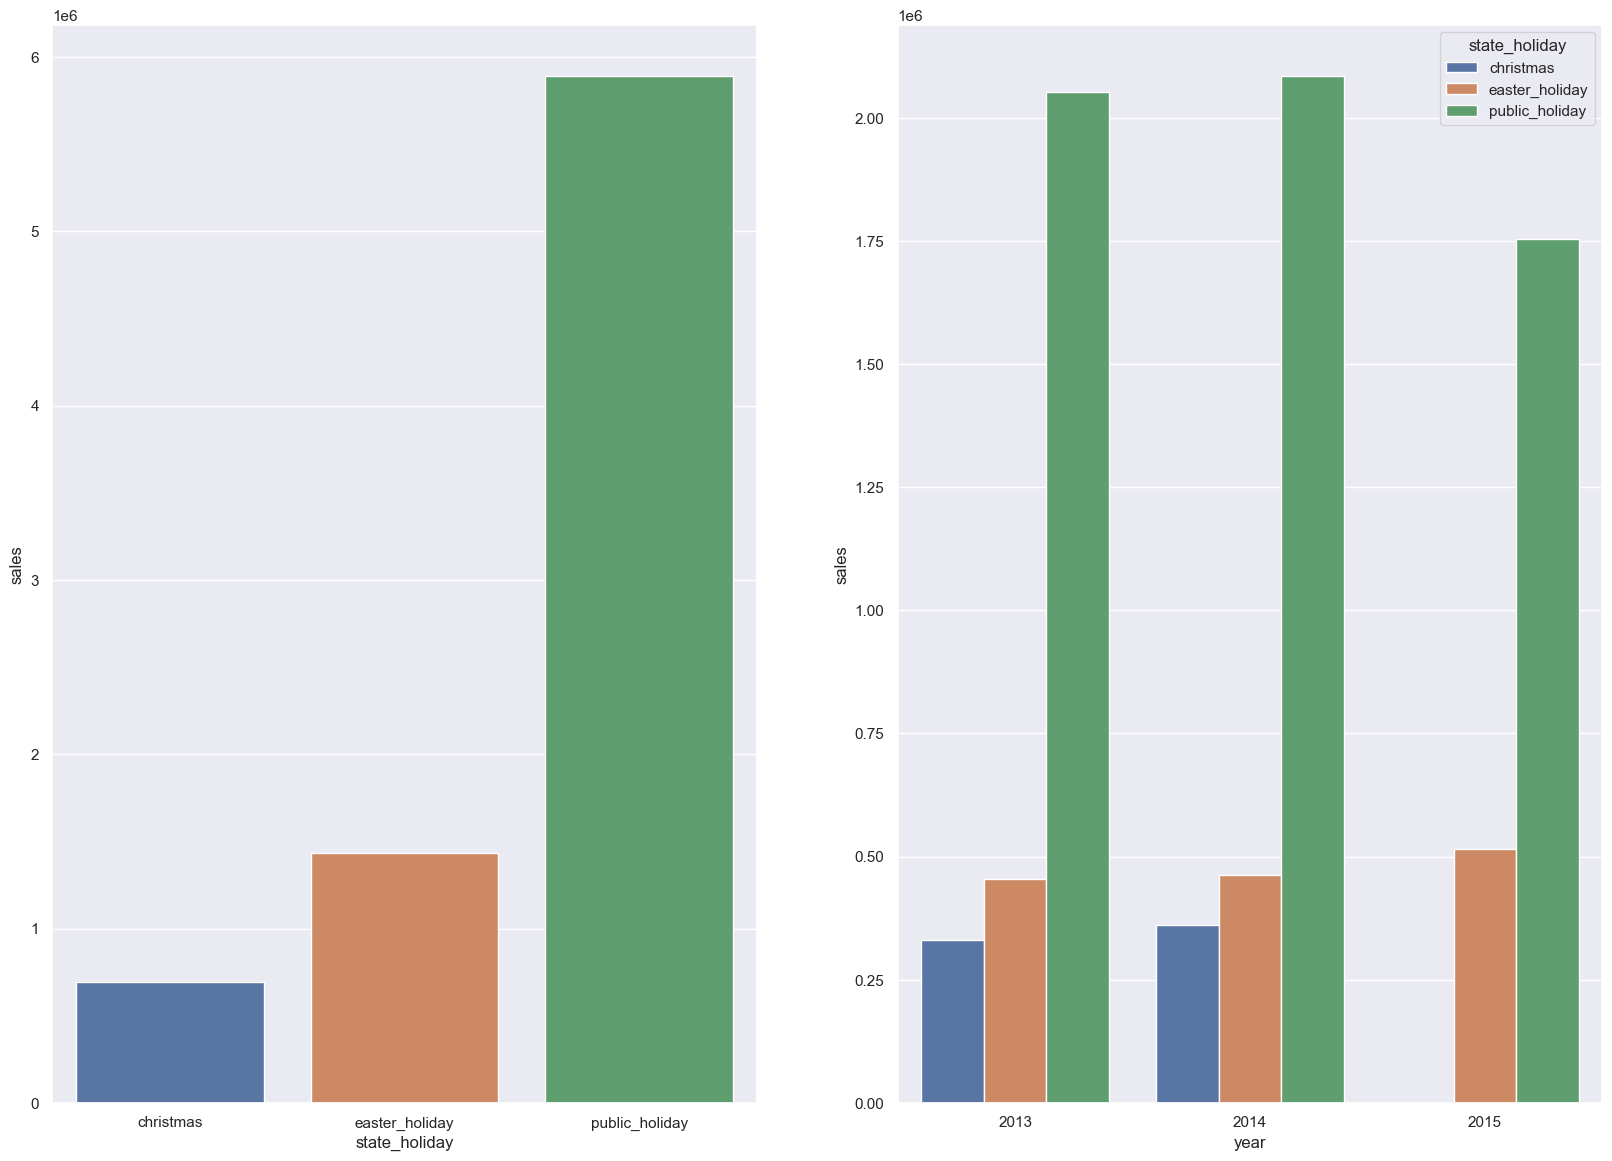

In [40]:
aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux2 = aux1[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux2);

plt.subplot(1,2,2)
aux3 = aux1[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux3, hue = 'state_holiday' );


### **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem MENOS ao longo dos ANOS

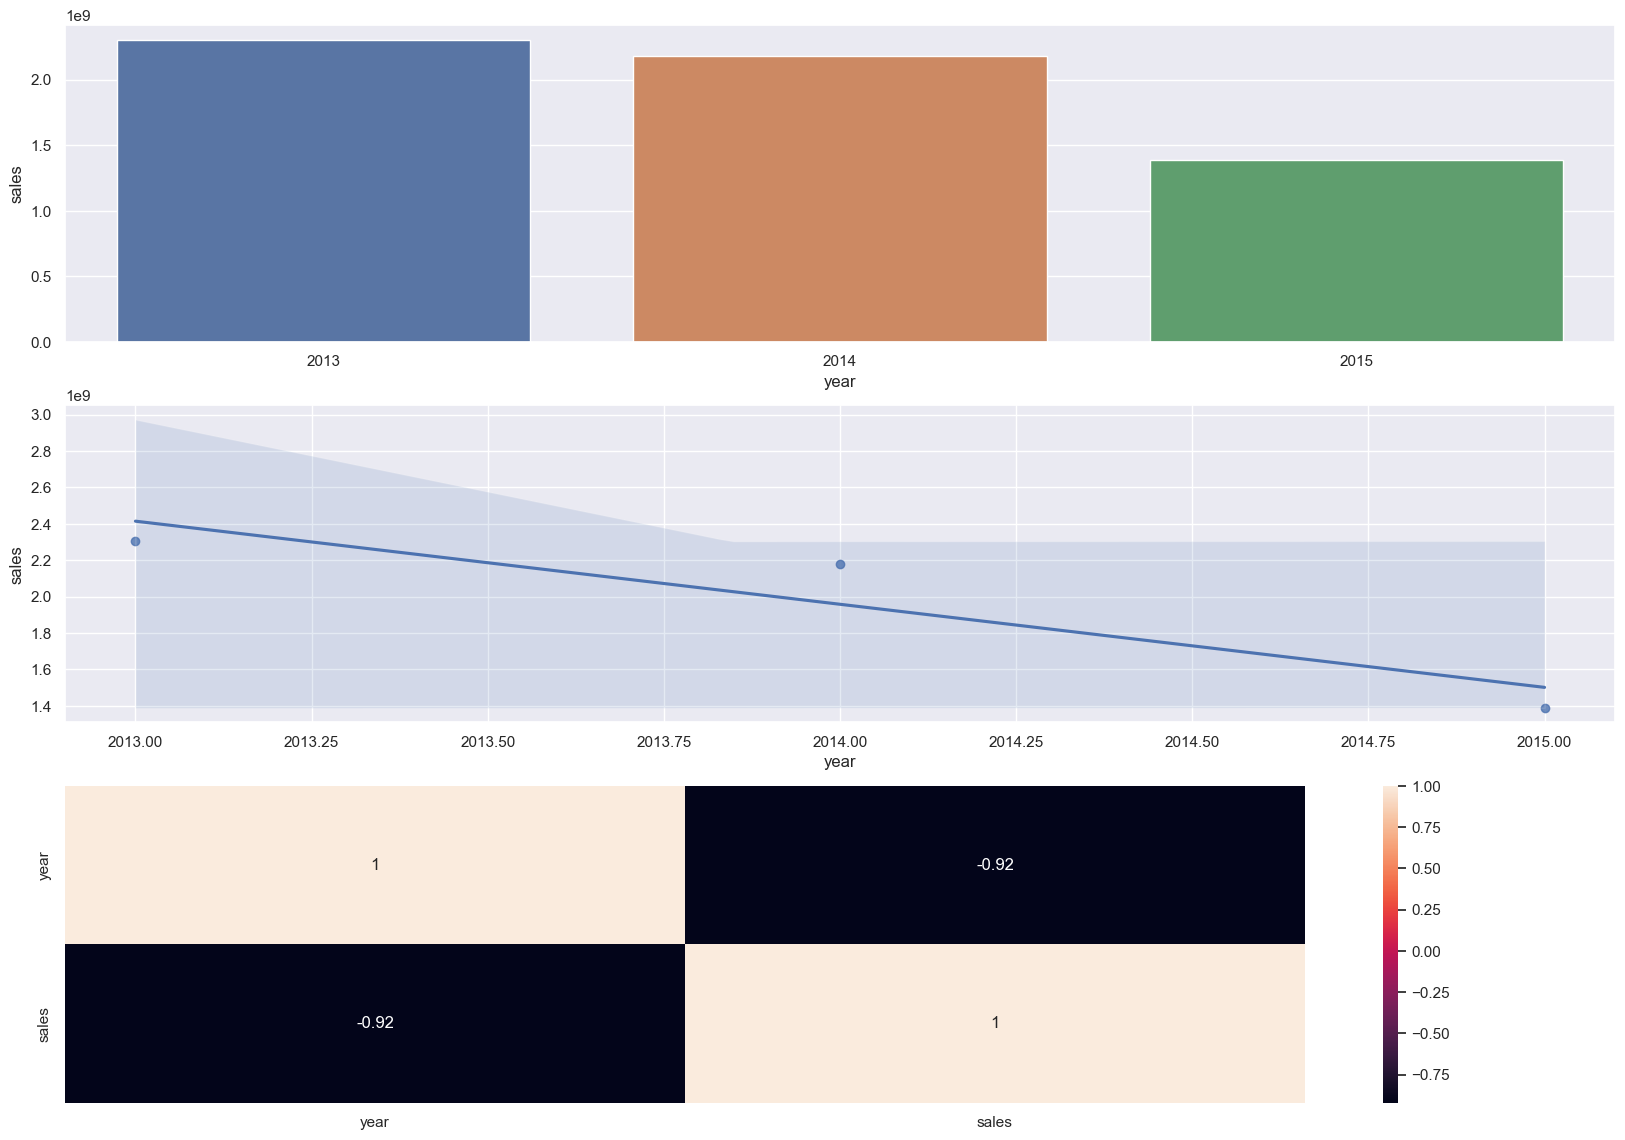

In [41]:
plt.subplot(3,1,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(3,1,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem MENOS no SEGUNDO SEMESTRE DO ANO

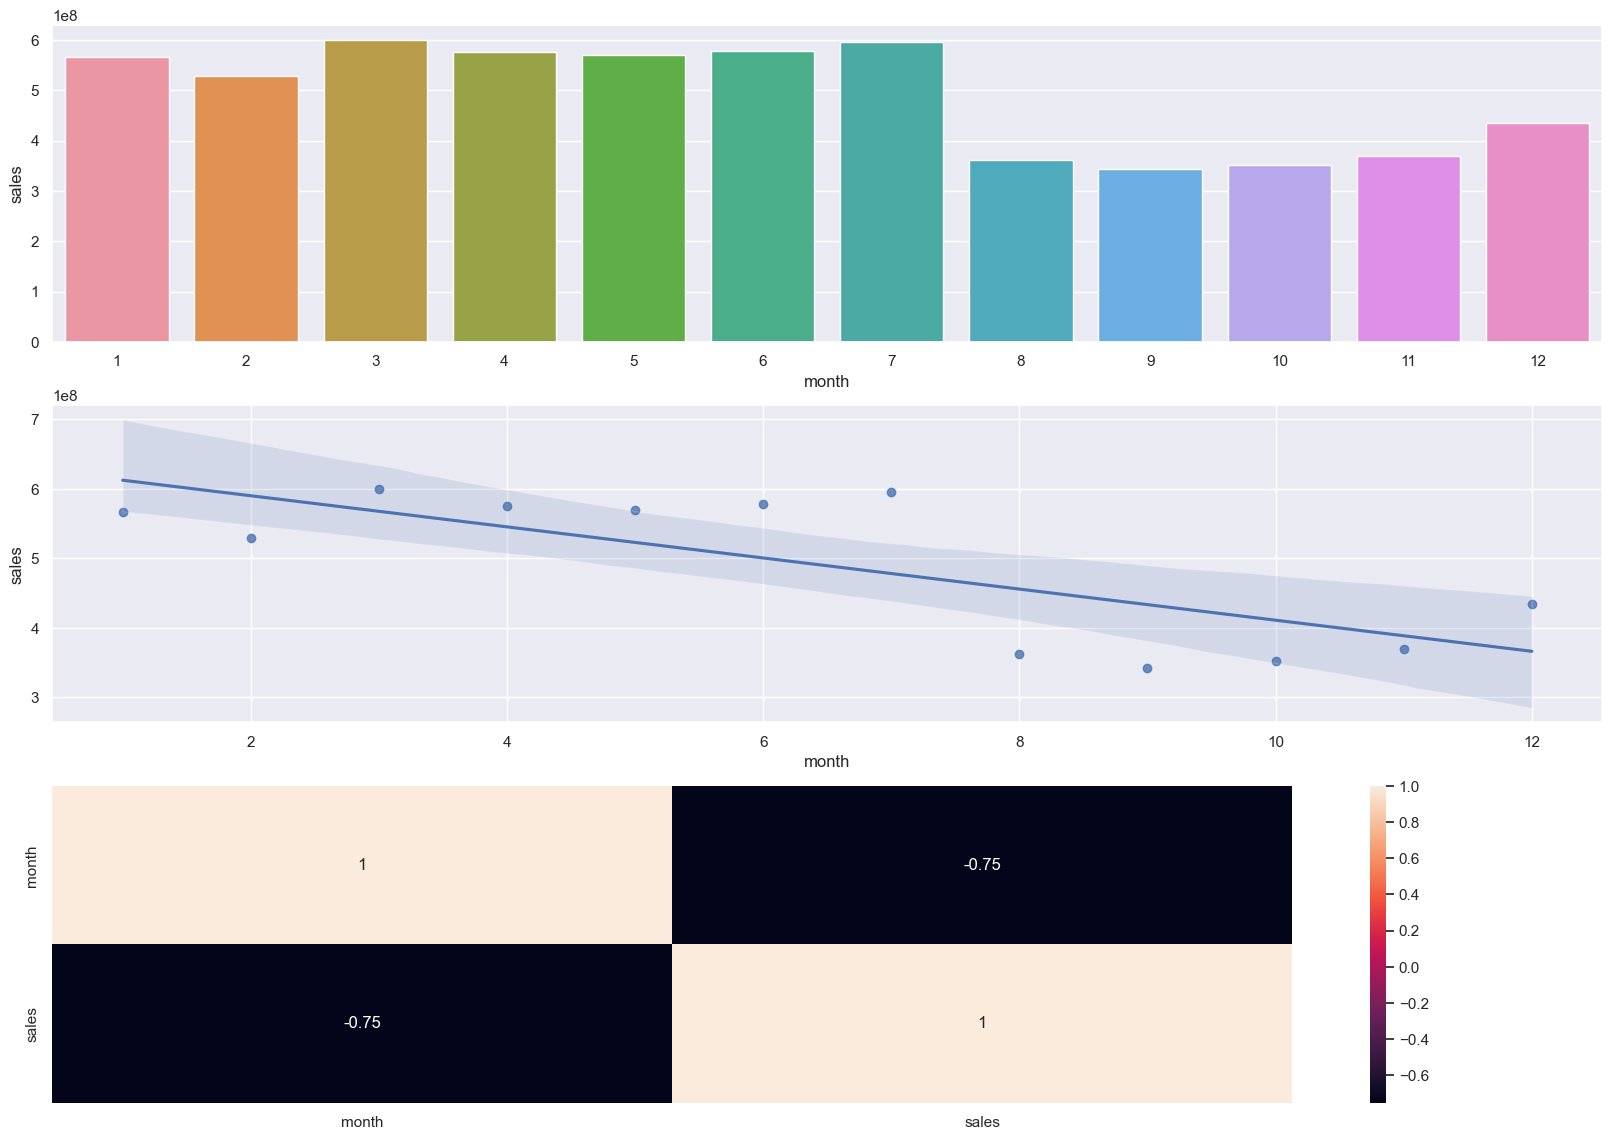

In [42]:
plt.subplot(3,1,1)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(3,1,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

<AxesSubplot: xlabel='before_after', ylabel='sales'>

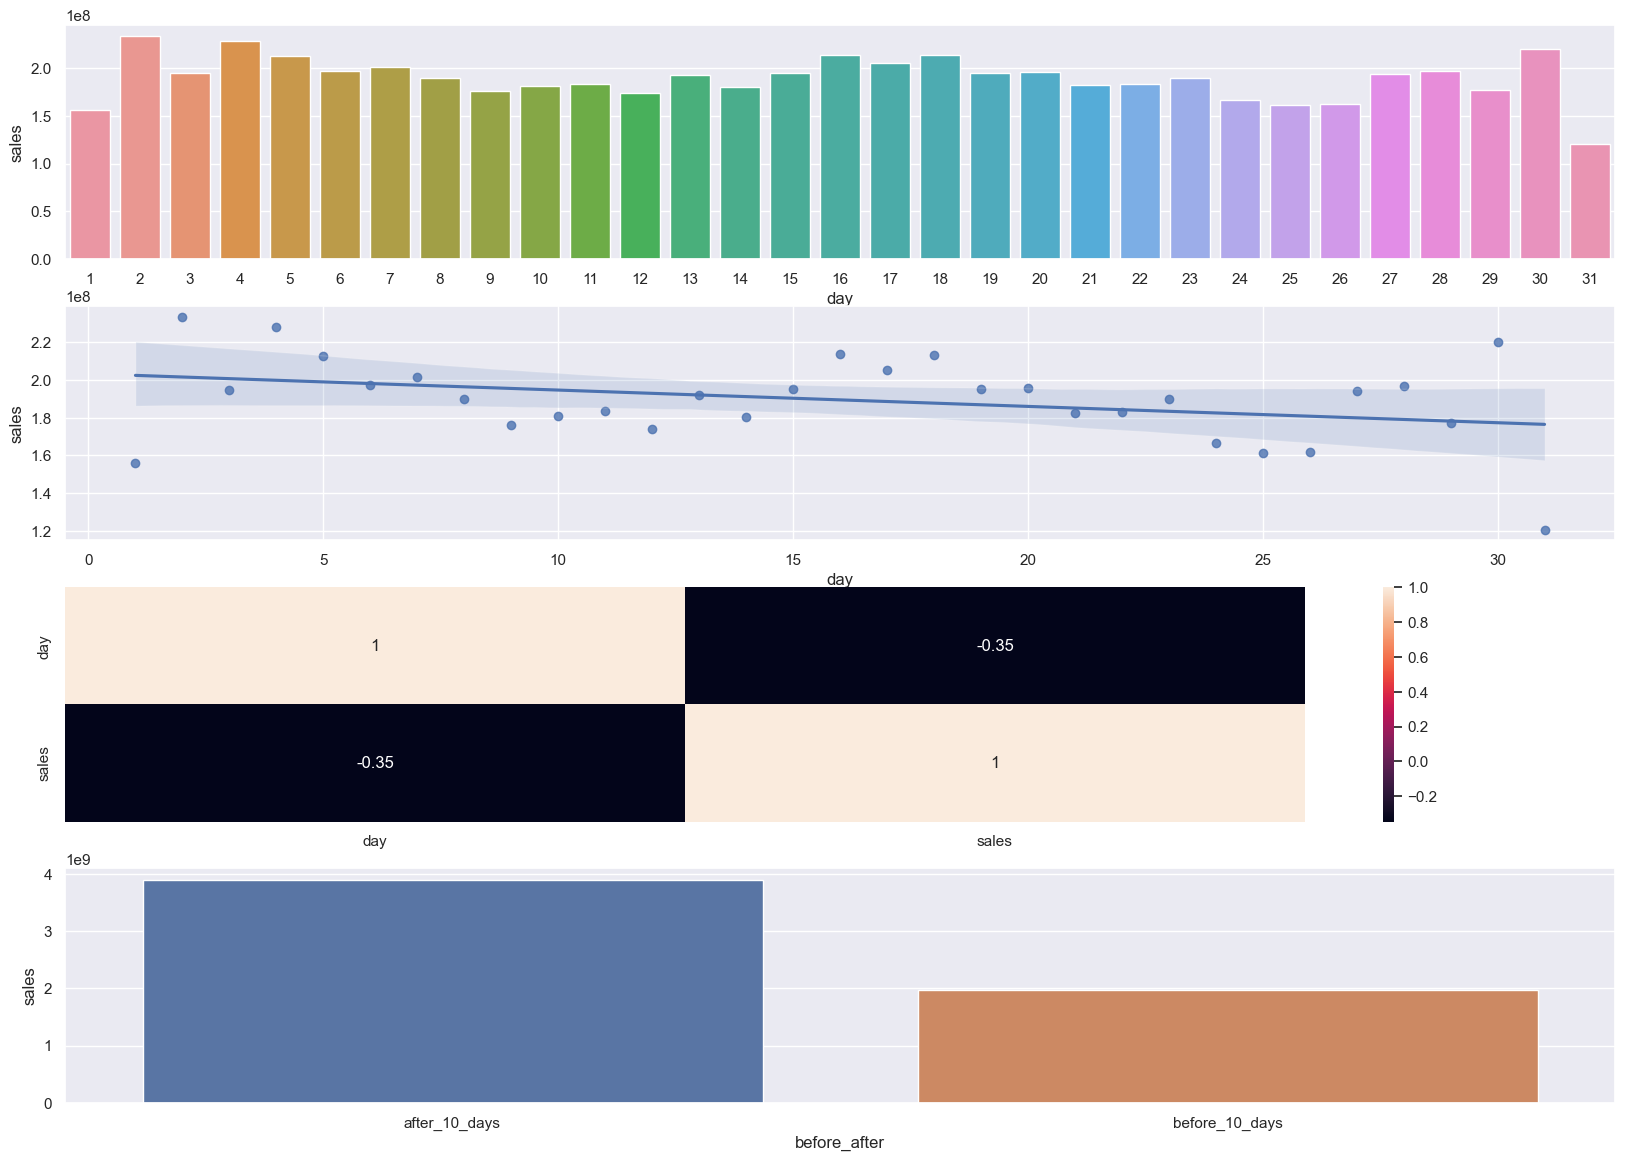

In [43]:
plt.subplot(4,1,1)
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(4,1,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(4,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(4,1,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2)

### **H11.** Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem MENOS nos FINAIS DE SEMANA

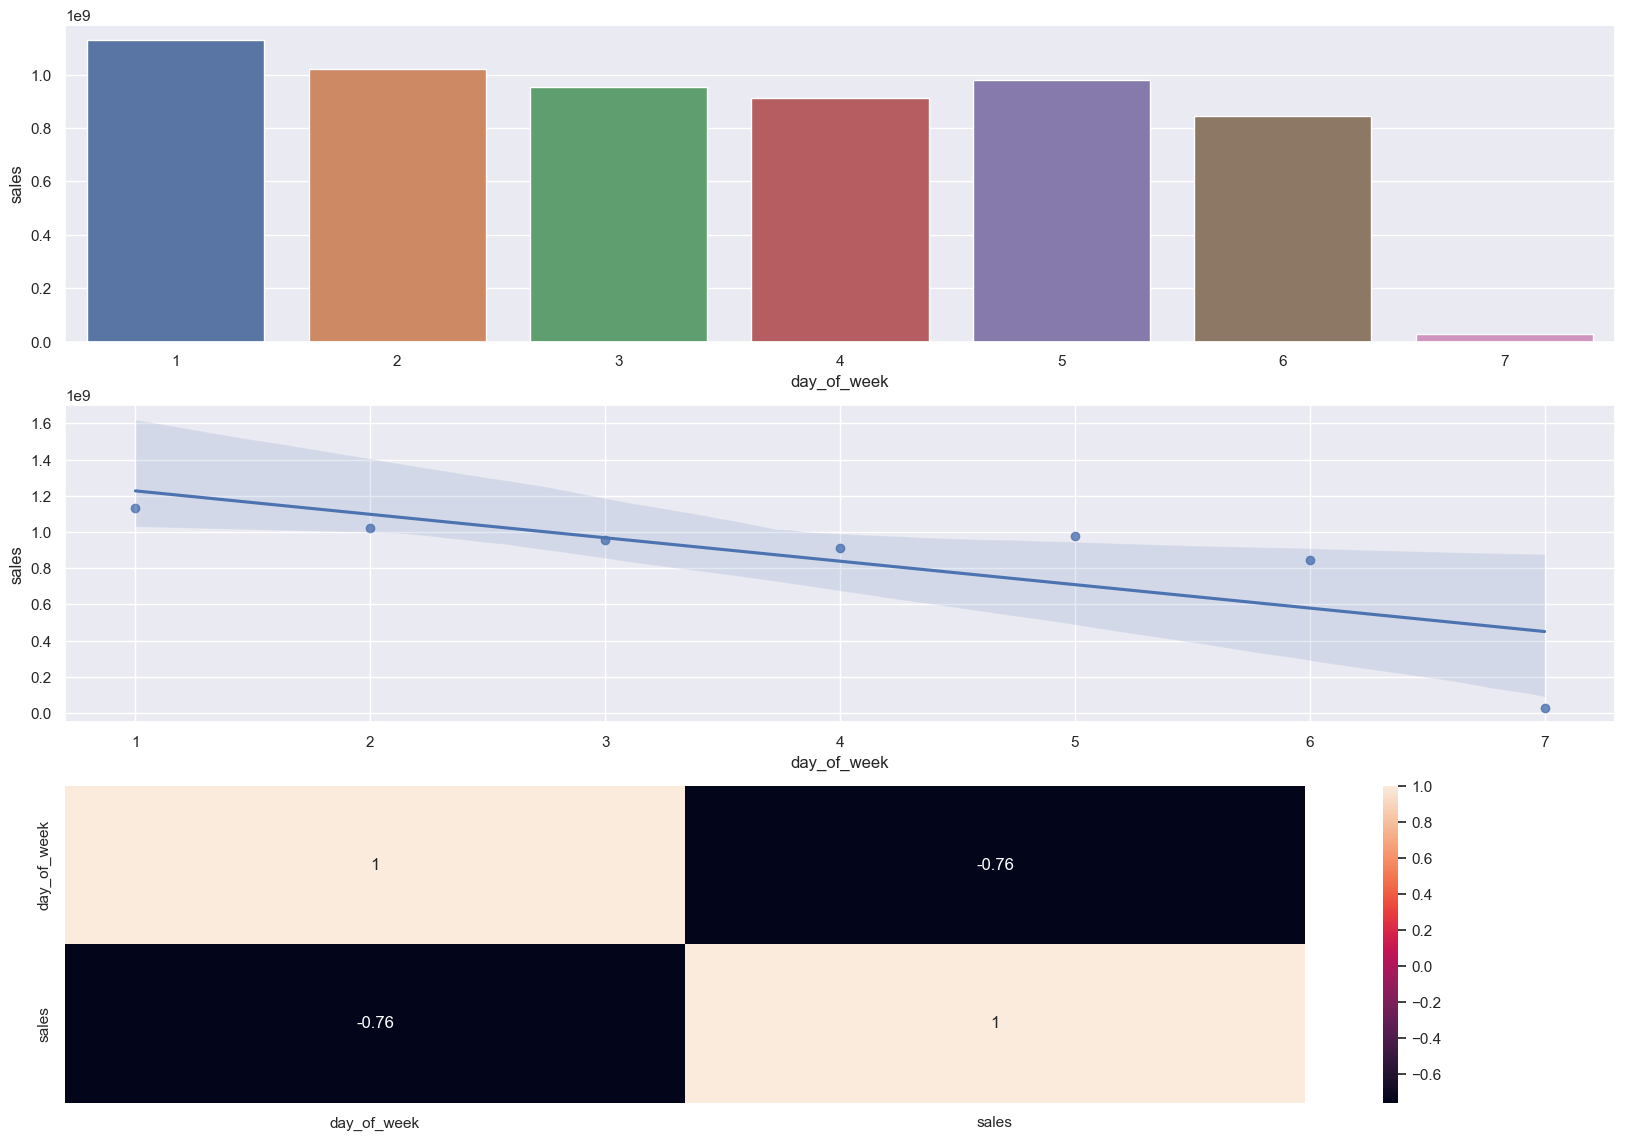

In [44]:
plt.subplot(3,1,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(3,1,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem MENOS nos FERIADOS ESCOLARES, exceto nos meses de agosto

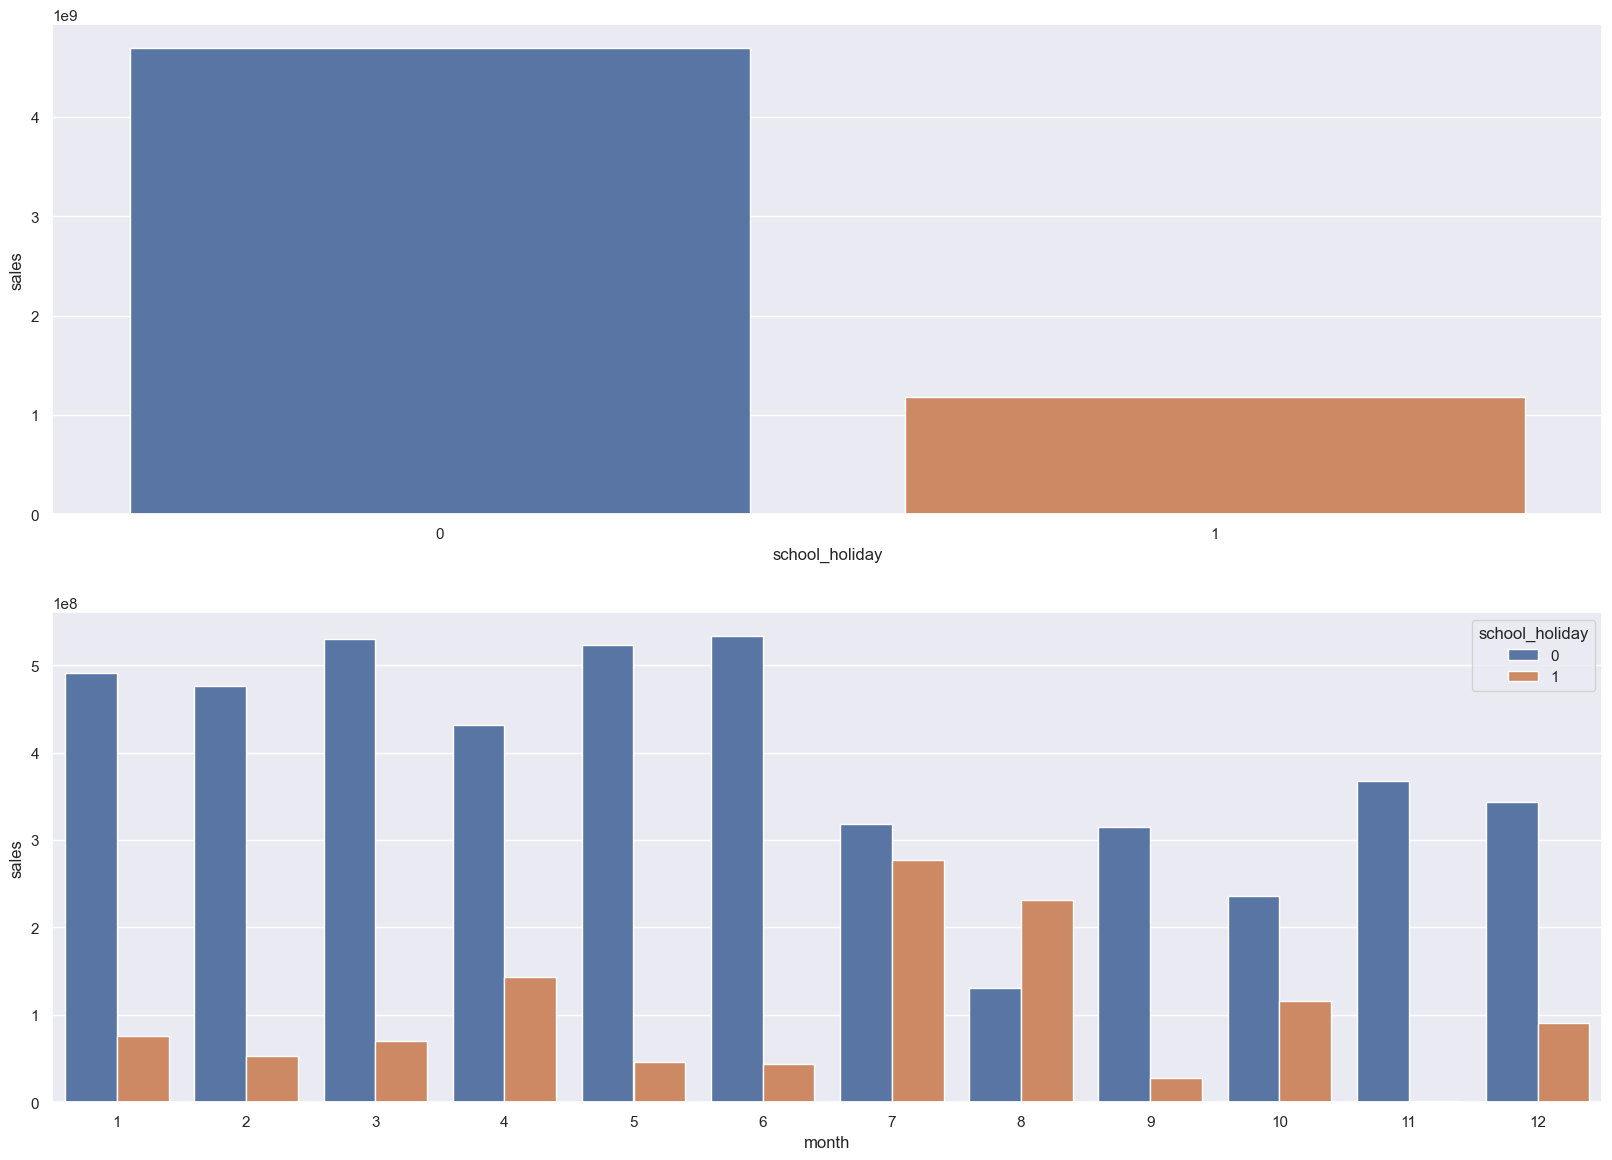

In [45]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### 4.2.1. Resumo das Hipoteses

In [46]:
tab = [
    ['Hipotese','Conclusao','relevancia'],
    ['H1','Falsa','Baixa'],
    ['H2','Falsa','Media'],
    ['H3','Falsa','Media'],
    ['H4','Falsa','Baixa'],
    ['H5','-','-'],
    ['H6','Falsa','Baixa'],
    ['H7','Falsa','Media'],
    ['H8','Falsa','Alta'],
    ['H9','Falsa','Alta'],
    ['H10','Verdadeira','Alta'],
    ['H11','Verdadeira','Alta'],
    ['H10','Verdadeira','Baixa'],
]
print(tabulate( tab, headers = 'firstrow'))

Hipotese    Conclusao    relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H10         Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot: >

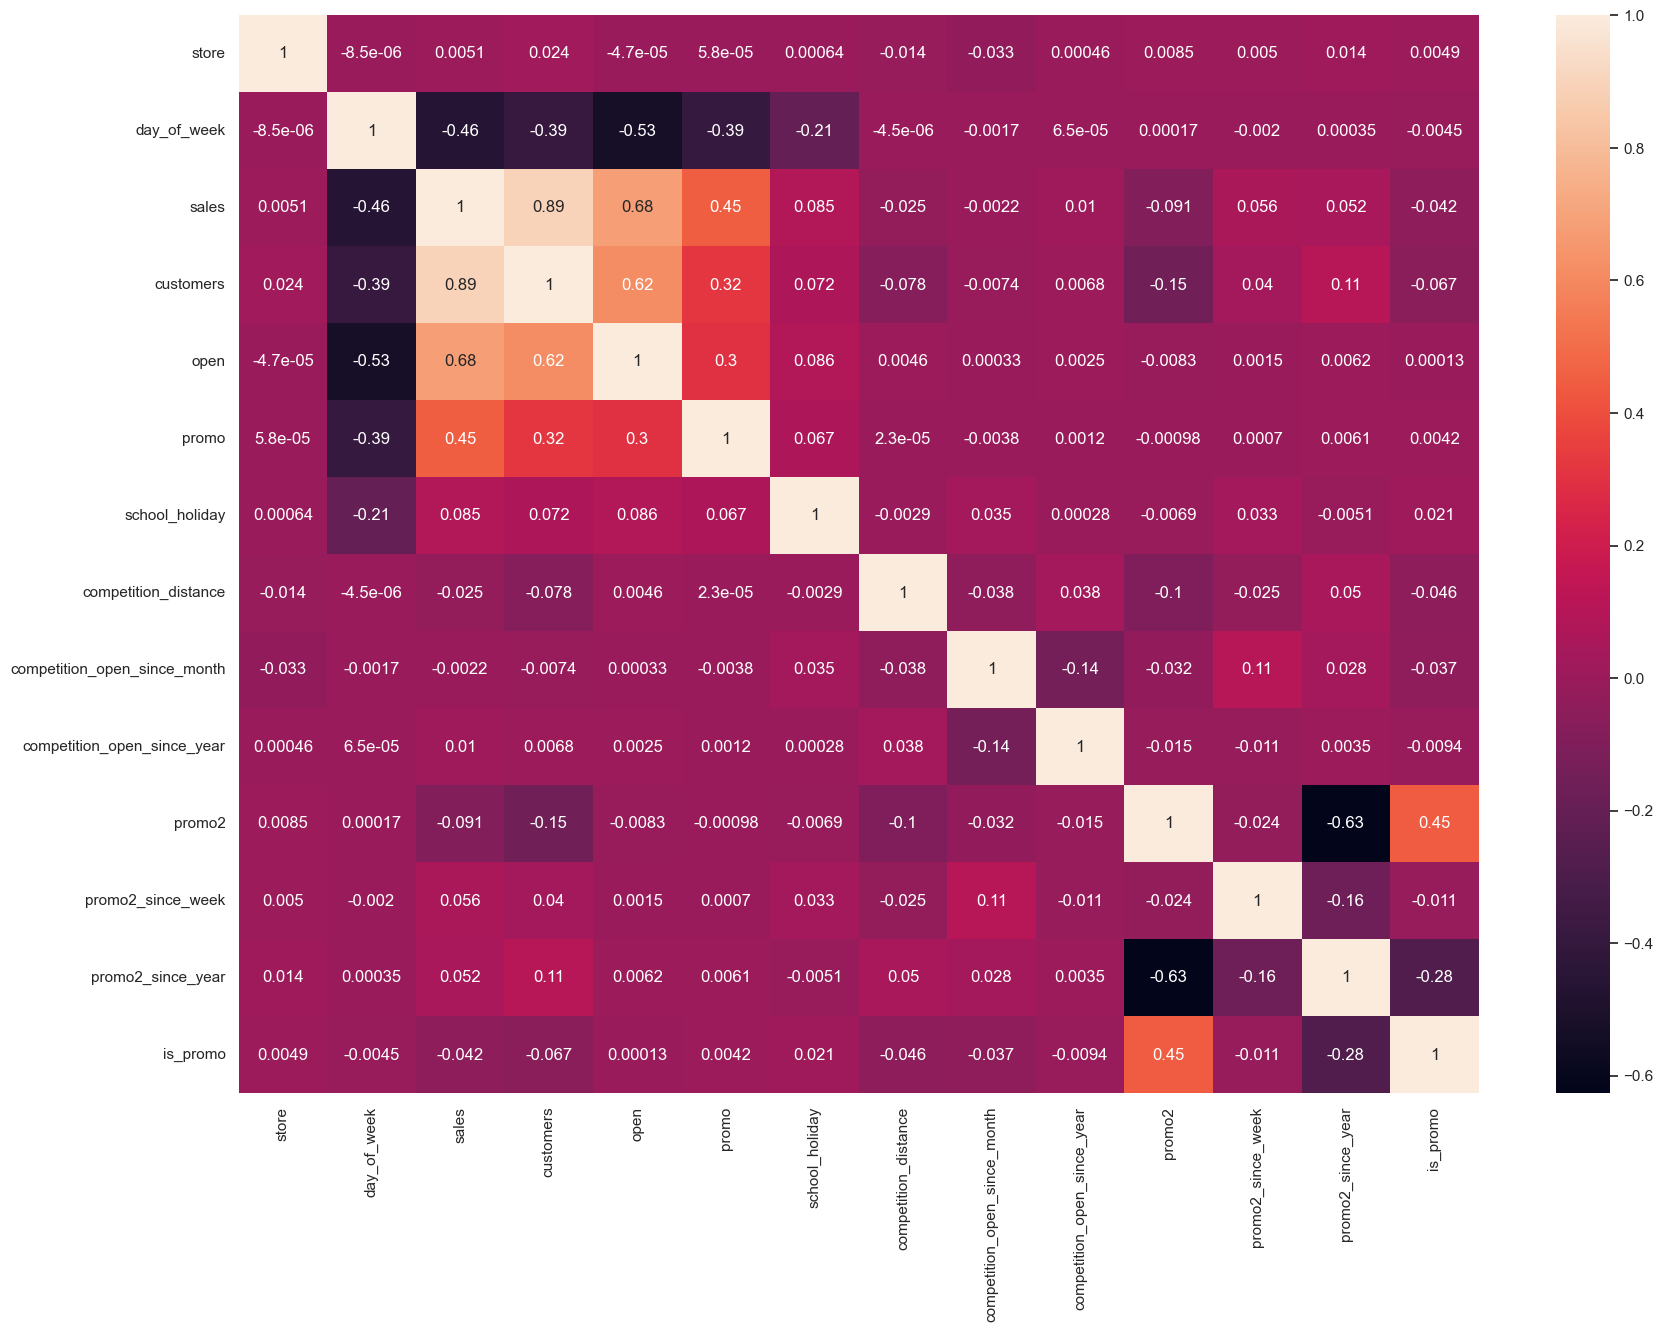

In [47]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2. Categorical Attributes

<AxesSubplot: >

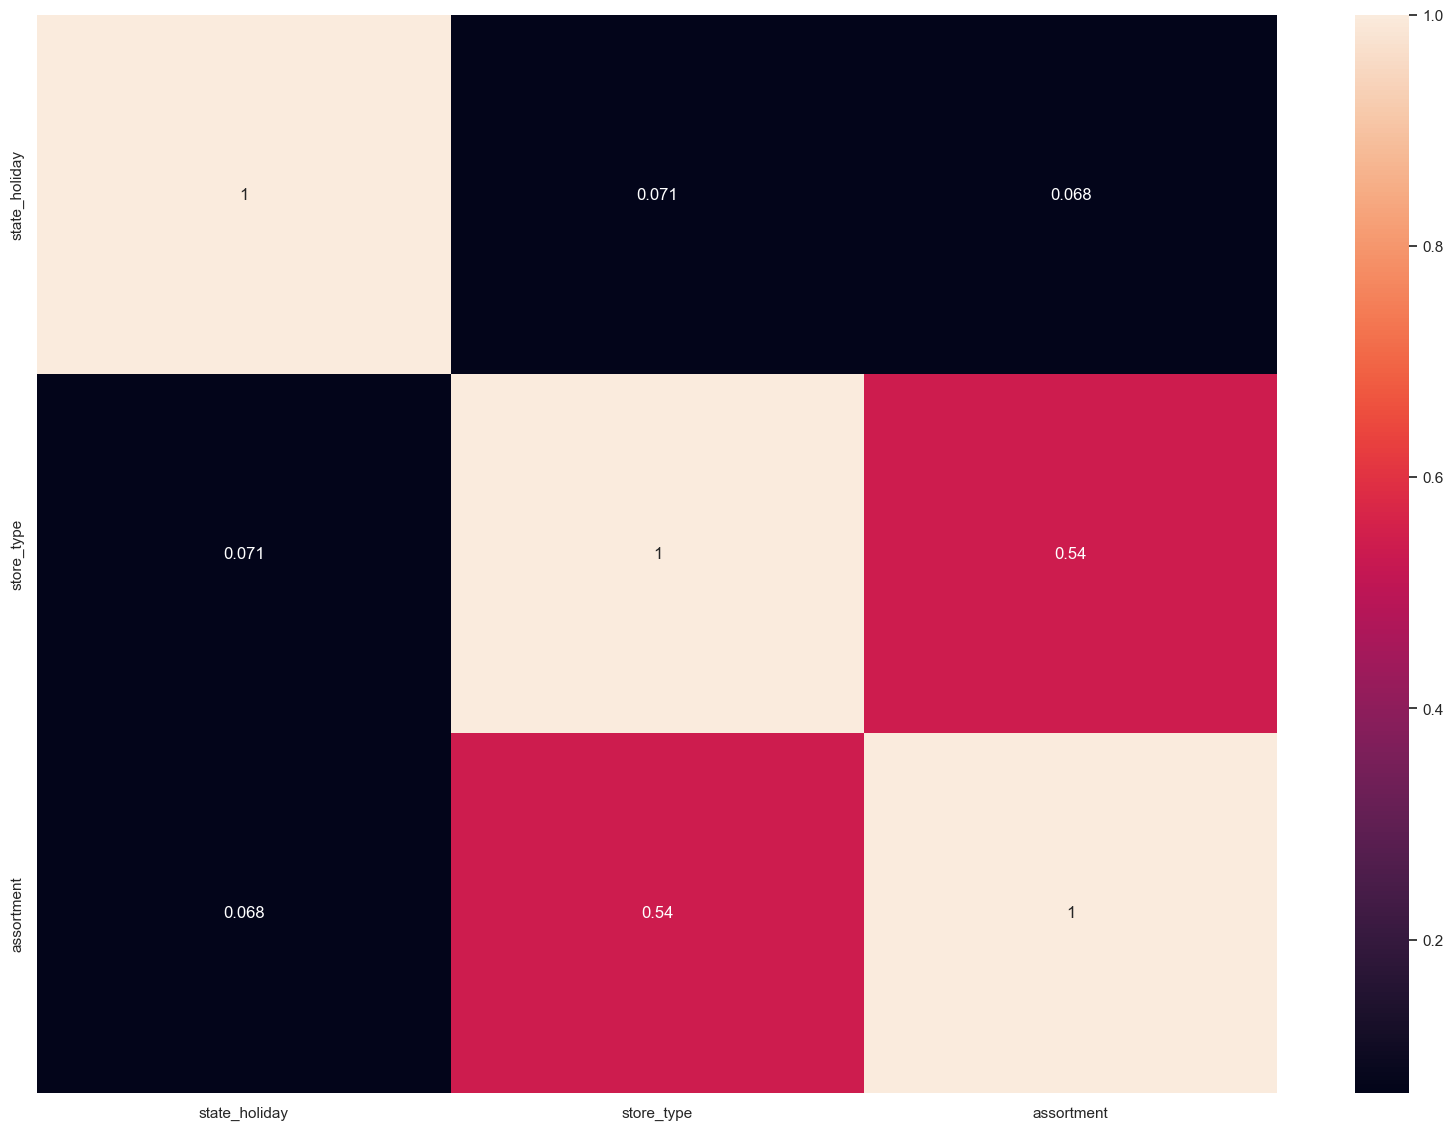

In [48]:
#only categorical data
a = df4.select_dtypes(include = ['object'])

#calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],
             })

d = d.set_index(d.columns)

sns.heatmap(d, annot = True)

# 5.0. PASSO 05 - DATA PREPARATION

In [77]:
df5 = df4.copy()

## 5.1. Normalizacao

In [50]:
#Foi buscar distribuição normal nas variáveis Univariadas (Numerical Variable), mas não foi encontrada nenhuma variável normal.

## 5.2. Rescaling

In [78]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformacao

### 5.3.1. Encoding

In [79]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [80]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2. Nature Transformation

In [81]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
